<font color=gray>ADS Sample Notebook.

Copyright (c) 2019,2021 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Deploying Machine Learning Models to Oracle Functions </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team</font></p>

***

**Note: Egress to the public internet is necessary to access the external links inserted in this notebook. Make sure your VCN and subnet are properly configured to access the public internet**

## Overview of this Notebook
This notebook provides a comprehensive overview on model deployment to Oracle Functions.

[Oracle Functions](https://docs.cloud.oracle.com/iaas/Content/Functions/Concepts/functionsoverview.htm) is based on the open source [Fn Project](https://fnproject.io/). Take a look at their website for more details on the `fn` CLI. You will use Cloud Shell to set up the `fn` CLI, build, deploy and invoke a Function.   Cloud Shell is a web-based terminal accessible from the Oracle Cloud Console.  It is free to use, and the Oracle CLI, Functions and Docker are pre-installed.  Cloud Shell comes with 5GB of persistent storage for the home directory, so you can make changes to your home directory and then continue working on your project when you come back to Cloud Shell. You can read more about Cloudshell [here](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/cloudshellintro.htm)

Cloud hosted machine learning is used in some way or another across many industries, and is rapidly expanding. The goals of this notebook are to: 
 - allow data scientists to deploy the model as a Function. The Function can serve as the backend to an API via the Oracle Cloud Infrastructure API Gateway service; 
 - allow data scientists to integrate their models into external applications by calling models via REST.
 
---

## Objectives:
These are the different sections we cover in this notebook: 
 - <a href='#disclaimer'>Disclaimer</a>
 - <a href='#load'>Loading the Data</a> using ADS.
 - <a href='#model'>Building and Training Simple Sklearn Models</a> 
 - <a href='#mc'>Saving the Models to the Model Catalog</a> 
      - <a href='#prepare'>Preparing the Model Artifact for use with Oracle Functions</a>
      - <a href='#prepare2'>Preparing a Generic Model</a>
      - <a href='#customize'>Customizing Input Data Format and Model Response </a>
 - <a href='#delete'>Delete Example Models from the Catalog</a>     
 - <a href='#deploy-with-cloud-shell'>Deploy Functions with Cloud Shell</a>
      - <a href='#tenancy-setup'>Oracle Cloud Infrastructure Tenancy Setup</a>
      - <a href='#download-model-artifact'>Download Model Artifacts</a>
      - <a href='#set-up-fn-cli'>Set up fn CLI</a>
      - <a href='#create-deploy-invoke-functions'>Create, Deploy, Invoke Functions</a>
 - <a href='#api-gateway'>Using Oracle Functions as a Backend Source of the Oracle Cloud Infrastructure API Gateway</a>
 ***
 <a id='setup'></a>
 
 <a id='disclaimer'></a>
## Disclaimer about Models that are Compatible with Oracle Functions

Oracle Fn is compatible with ADSModels that have been prepared (or <a href='#model2'>prepared generically</a>) and saved to the Model Catalog. Many types of models can be prepared with ADS (XGBoost, LightGBM, Sklearn, PyTorch, and AutoML) but some may need to be <a href='#model2'>prepared generically</a> or be converted to an ONNX serialized model manually (some examples include Tensorflow, MXNet, and H2O).

Start by importing the necessary Python libraries. We will need ADS to prepare and save a model artifact to the model catalog. The artifact object includes the necessary files to deploy the model as a `Function`. 

In [ ]:
import ads
import cloudpickle
import logging
import os
import tempfile
import warnings

from ads.dataset.factory import DatasetFactory
from ads.dataset.dataset_browser import DatasetBrowser
from ads.common.model import ADSModel
from ads.common.model_export_util import prepare_generic_model
from ads.catalog.model import ModelSummaryList, ModelCatalog
from ads.catalog.project import ProjectSummaryList, ProjectCatalog
from ads.catalog.summary import SummaryList
from ads.common.model_artifact import ModelArtifact
from os import path
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

#set this to True if you want to see detailed logs of ADS calls
ads.set_debug_mode(False)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')

<a id='load'></a>
## Loading The Data

<font color=gray> (You can load from: a local or network file system, Hadoop Distributed File System, Amazon S3, Google Cloud Service, Pandas, Dask, or H2O. And in any of the following formats: CSV, TSV, Parquet, libsvm, json, Excel, HDF5, SQL, xml, apache server log files (clf, log) and arff.)</font>

We are going to train a simple ML model. To get started, use the ADS `DatasetBrowser` object to pull the iris dataset from sklearn. ADS will convert the dataset into a Dask dataframe. While loading the data to memory, ADS will also create a sampled dataset that will be used to speed up visualizations. A progress bar indicates the progress of these operations to the user.

<font color=gray> If you don't yet know the target in your project, you can explore the data first and set the target later.</font>

<font color=gray>Datasets are provided as a convenience.  Datasets are considered Third Party
Content and are not considered Materials under Your agreement with Oracle
applicable to the Services. The `iris` dataset has a standard BSD 3 clause license [learn more here](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#). 
</font>

In [ ]:
ds = DatasetBrowser.sklearn().open("iris")
train, test = ds.train_test_split()
iris_X, iris_y = train.X, train.y

<a id='model'></a>
## Building and Training Simple Sklearn Models

Next step is to create our model that we will later deploy to `Functions`. Here we will demonstrate deploying a simple sklearn model in a pipeline with some simple preprocessing.

First we will build the model, here we chose a simple RandomForestClassifier:

In [ ]:
rf = RandomForestClassifier()
rf.fit(iris_X, iris_y)

Next we will bundle this model into a pipeline with some preprocessing. Here we use a Standard Scaler preprocessing function from sklearn. Finally we bundle this in a Pipeline and re-fit. Read more about pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
pipe.fit(iris_X, iris_y)

Now that we have trained our model, we can convert it into an ADSModel.

In [ ]:
adspipe = ADSModel.from_estimator(pipe)

The final model is: `adspipe`. In the next section, we are going to save these models to the model catalog. 

<a id='mc'></a>
## Saving the Models to the Model Catalog 

<a id='prepare'></a>
### Preparing the Model Artifact for Oracle Functions 
 
The first step when saving models to the model catalog is to create a model artifact for each model. For additional information on the model catalog, please consult the example notebook `model_catalog.ipynb`. 

When you prepare the artifact using the `prepare()` method, you can also create the files that are necessary for `Function` deployment by setting the optional parameter ```fn_artifact_files_included=True``` (which defaults to True). You may also set the function name in `fn_name` parameter. `fn_name` will set the name of your function in `func.yaml`. 

When you keep ```fn_artifact_files_included=True```, the following files are created in the model artifact file. 

*Note that `score.py`, `model.onnx`, `requirements.txt`, and `runtime.yaml` are still present in the artifact. These files are not modified.* 

<pre> [model-artifact-folder]/
   + func.py
   + func.yaml
   + model.onnx
   + requirements.txt
   + runtime.yaml
   + score.py</pre>

A few remarks on the files in the model artifact folder : 

* `model.onnx` is the serialized model estimator. It has no ADS requirements. It's currently being serialized by Onnx.

* the `requirements.txt` file will contain the libraries required by the core estimator. The version numbers provided will be the ones that are compatible with the notebook session environment. 

* `func.py` and `func.yaml` are templatized and pre-written on your behalf. In principle, you do not need to modify these files unless you want to include additional data transformations steps before passing the data to the estimator object.

* `runtime.yaml` stores information about the environment in which you save the model. This will help with reproducibilty.

If we also pass in X-sample, y_sample, and include_data_sample=True, we generate the additional files:
<pre> [model-artifact-folder]/
   + data-sample.json
   + schema.json</pre>
   
   
* `data-sample.json` will be a properly formatted json file with the data from X-sample. This will be helpful for verifying the deployment (as demonstrated below).

* `schema.json` stores several features about the data, such as data types, problem type (classification v regression), etc, as well as the y_sample.

In [ ]:
model_artifact_fn = adspipe.prepare(path.join(path.expanduser("~"), "pipe_model_artifact"), force_overwrite=True, 
                                    X_sample=iris_X[:5], y_sample=iris_y[:5], include_data_sample=True,
                                    fn_artifact_files_included=True, fn_name="predictor", data_science_env=True)

Let us take a look at the content of the relevant fn files in the model artifact folder (In our case that's `~/pipe_model_artifact`.)

### `func.yaml`

`func.yaml` contains the definition of the Function runtime environment. By default we set the memory to 1024 Mb. We expect the runtime environment to match the notebook environment (Python 3.6). For more information about `func.yaml`, please review the section ["Understand func.yaml"](https://fnproject.io/tutorials/python/intro/#Understandfunc.yaml) in the fnproject.io documentation. 

```shell 
cat /home/datascience/pipe_model_artifact/func.yaml
```
<hr/>

```yaml
entrypoint: /python/bin/fdk /function/func.py handler
memory: 1024
name: predictor
runtime: python3.6
schema_version: 20180708
version: 0.0.1
```

### `func.py` 

`func.py` defines the handler function. This is the Python function that will be called every time you invoke your `Function`. 

Here we assume your data is in JSON format and that the data are values of the `input` key. We simply pass that data to `score.predict`. 

```shell
cat /home/datascience/pipe_model_artifact/func.py
```
<hr/>

```python
import io
import json

from fdk import response
import sys
sys.path.append('/function')
import score

model = score.load_model()

def handler(ctx, data: io.BytesIO=None):

    input = json.loads(data.getvalue())['input']
    prediction = score.predict(input, model)


    return response.Response(
        ctx, response_data=json.dumps(prediction),
        headers={"Content-Type": "application/json"}
    )
```

### `score.py` 

`score.py` is specific to the Oracle Cloud Infrastructure Data Science service. This file contains functions definition that load the model to memory (`load_model()`) and call the inference method of the estimator object (`predict()`).

```shell
cat /home/datascience/pipe_model_artifact/score.py
```
<hr/>

```python
import json
import numpy as np
import onnxruntime as rt
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder


model_name = 'model.onnx'
transformer_name = 'onnx_data_transformer.json'


"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""


def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model:  an onnxruntime session instance
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file_name in contents:
        return rt.InferenceSession(os.path.join(model_dir, model_file_name))
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model session instance returned by load_model API
    data: Data format as expected by the onnxruntime API

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    from pandas import read_json, DataFrame
    from io import StringIO
    X = read_json(StringIO(data)) if isinstance(data, str) else DataFrame.from_dict(data)
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    # Note: User may need to edit this
    if transformer_name in contents:
        onnx_data_transformer = ONNXTransformer()
        onnx_data_transformer.reload_serialized(os.path.join(model_dir, transformer_name))
        X, _ = onnx_data_transformer.transform(X)
    else:
        onnx_data_transformer = None
    
    onnx_transformed_rows = []
    for name, row in X.iterrows():
        onnx_transformed_rows.append(list(row))
    input_data = {'input': onnx_transformed_rows}
    
    pred = model.run(None, input_data)
    return {'prediction':pred[0].tolist()}
```

### requirements.txt 

`requirements.txt` includes the Python libraries that are necessary to run the model as a Function. The versions of these libraries match what is available on the notebook session environment. We also include a few libraries by default, including `pandas`, `numpy`, `onnxruntime`, `fdk`, and `scipy`. 

You will need to modify this file and add your own library dependencies if you decide to modify `func.py` or `score.py`. 

```shell 
cat /home/datascience/pipe_model_artifact/requirements.txt
```
<hr/>

<pre>
scikit-learn==[current-version-number]
fdk==[current-version-number]
numpy==[current-version-number]
pandas==[current-version-number]
onnxruntime==[current-version-number]
</pre>

<a id='prepare2'></a>
## Preparing a Generic Model

This sections details how to prepare and save a model that is not supported by `ADSModel` to the Model Catalog. Here we create Gamma Regression Model (Generalized Linear Model with a Gamma distribution and a log link function) from sklearn. `ADSModel` does not support this class of model so the Generic Model approach is used.

In [ ]:
gamma_reg_model = linear_model.GammaRegressor()
train_X = [[1, 2], [2, 3], [3, 4], [4, 3]]
train_y = [19, 26, 33, 30]
gamma_reg_model.fit(train_X, train_y)

In [ ]:
temp_path = tempfile.mkdtemp()
generic_model_artifact = prepare_generic_model(temp_path, force_overwrite=True, data_science_env=True)

# Serialize the model
with open(path.join(temp_path, "model.pkl"), "wb") as outfile:
    cloudpickle.dump(gamma_reg_model, outfile)

# List the template files\n",
print("Model Artifact Path: {}\n\nModel Artifact Files:".format(temp_path)),
for file in os.listdir(temp_path):
    if path.isdir(path.join(temp_path, file)):
        for file2 in os.listdir(path.join(temp_path, file)):
            print(path.join(file,file2))
    else:
        print(file)

<a id='customize'></a>
### Customizing Input Data Format and Model Response 

Your `Function` can be deployed as a REST endpoint. The default implementation assumes content type `application/json` and json format as - 
```javascript
{
    "input":list of list of features
}
```

Below is an example of four instances of an input feature array containing five features. These five features are passed to the inference function of the model: 

```
{"input":[[0.34038432,  0.58337375, -0.95106297,  1.3643036, 0.875723], [0.25526622, 0.08238148,  1.22733479, -3.25138188,  0.9557617], [1.72882038, 4.16767203,  0.66168448, -1.32352766,  0.2291577], [-1.36069979, -1.25679307, -0.9142609 ,  0.40959259,  0.65773237]]}
```


If you must change the structure of the JSON dataset, you will have to alter the following line in `func.py`
```python
input = json.loads(data.getvalue())['input']
```

`score.py` assumes that the input data does not need any processing and is in the format expected by `predict` function of the `estimator`. If the data needs pre-processing before passing to `predict` method of the estimator, you can add that code to `score.py` or directly to `func.py` 

`score.predict` returns a json - 
```javascript
{
    "prediction":output from predict() method of the estimator object
}
```
If you change the return type of `score.predict` from json to any other type, you will have to modify following line in `func.handler` - 
```python
return response.Response(
        ctx, response_data=json.dumps(prediction),
        headers={"Content-Type": "application/json"}
```

## Save Model Artifact to Catalog

Persist your model artifact in the catalog : 

In [ ]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

# Saving the model artifact to the model catalog: 
mc_model = model_artifact_fn.save(project_id=project_id, compartment_id=compartment_id, display_name="my_model",
                                 description="test description", training_script_path="model_deployment_fn.ipynb", 
                                 ignore_pending_changes=True)
mc_model

You can find more details about the model catalog, environment variables and `save` API in `model_catalog.ipynb` notebook

<a id='delete'></a>
## Delete Example Models from the Catalog

After we finished work with this example notebook we have to delete any example models saved in the Model Catalog. **Do not delete your own models, working notebook sessions and active projects, that have to be stored in cloud storage.** To delete our example model use `ModelCatalog().delete_model()` method, which requires the OCID of the model to delete as a string, or a Model instance. In this notebook we need to delete `mc_model`, with display name `my_model`.

In [ ]:
mc = ModelCatalog(compartment_id=compartment_id)
mc.delete_model(mc_model)

# to delete with id of model:
# mc.delete_model("model.id string starts with ocid1.")

<a id='deploy-with-cloud-shell'></a>
## Deploy `Function` with Cloud Shell

In this section we will guide you on the steps to use Cloudshell to deploy `Function`. To access Cloudshell, log into the Oracle Cloud Console and go to the top right corner. 

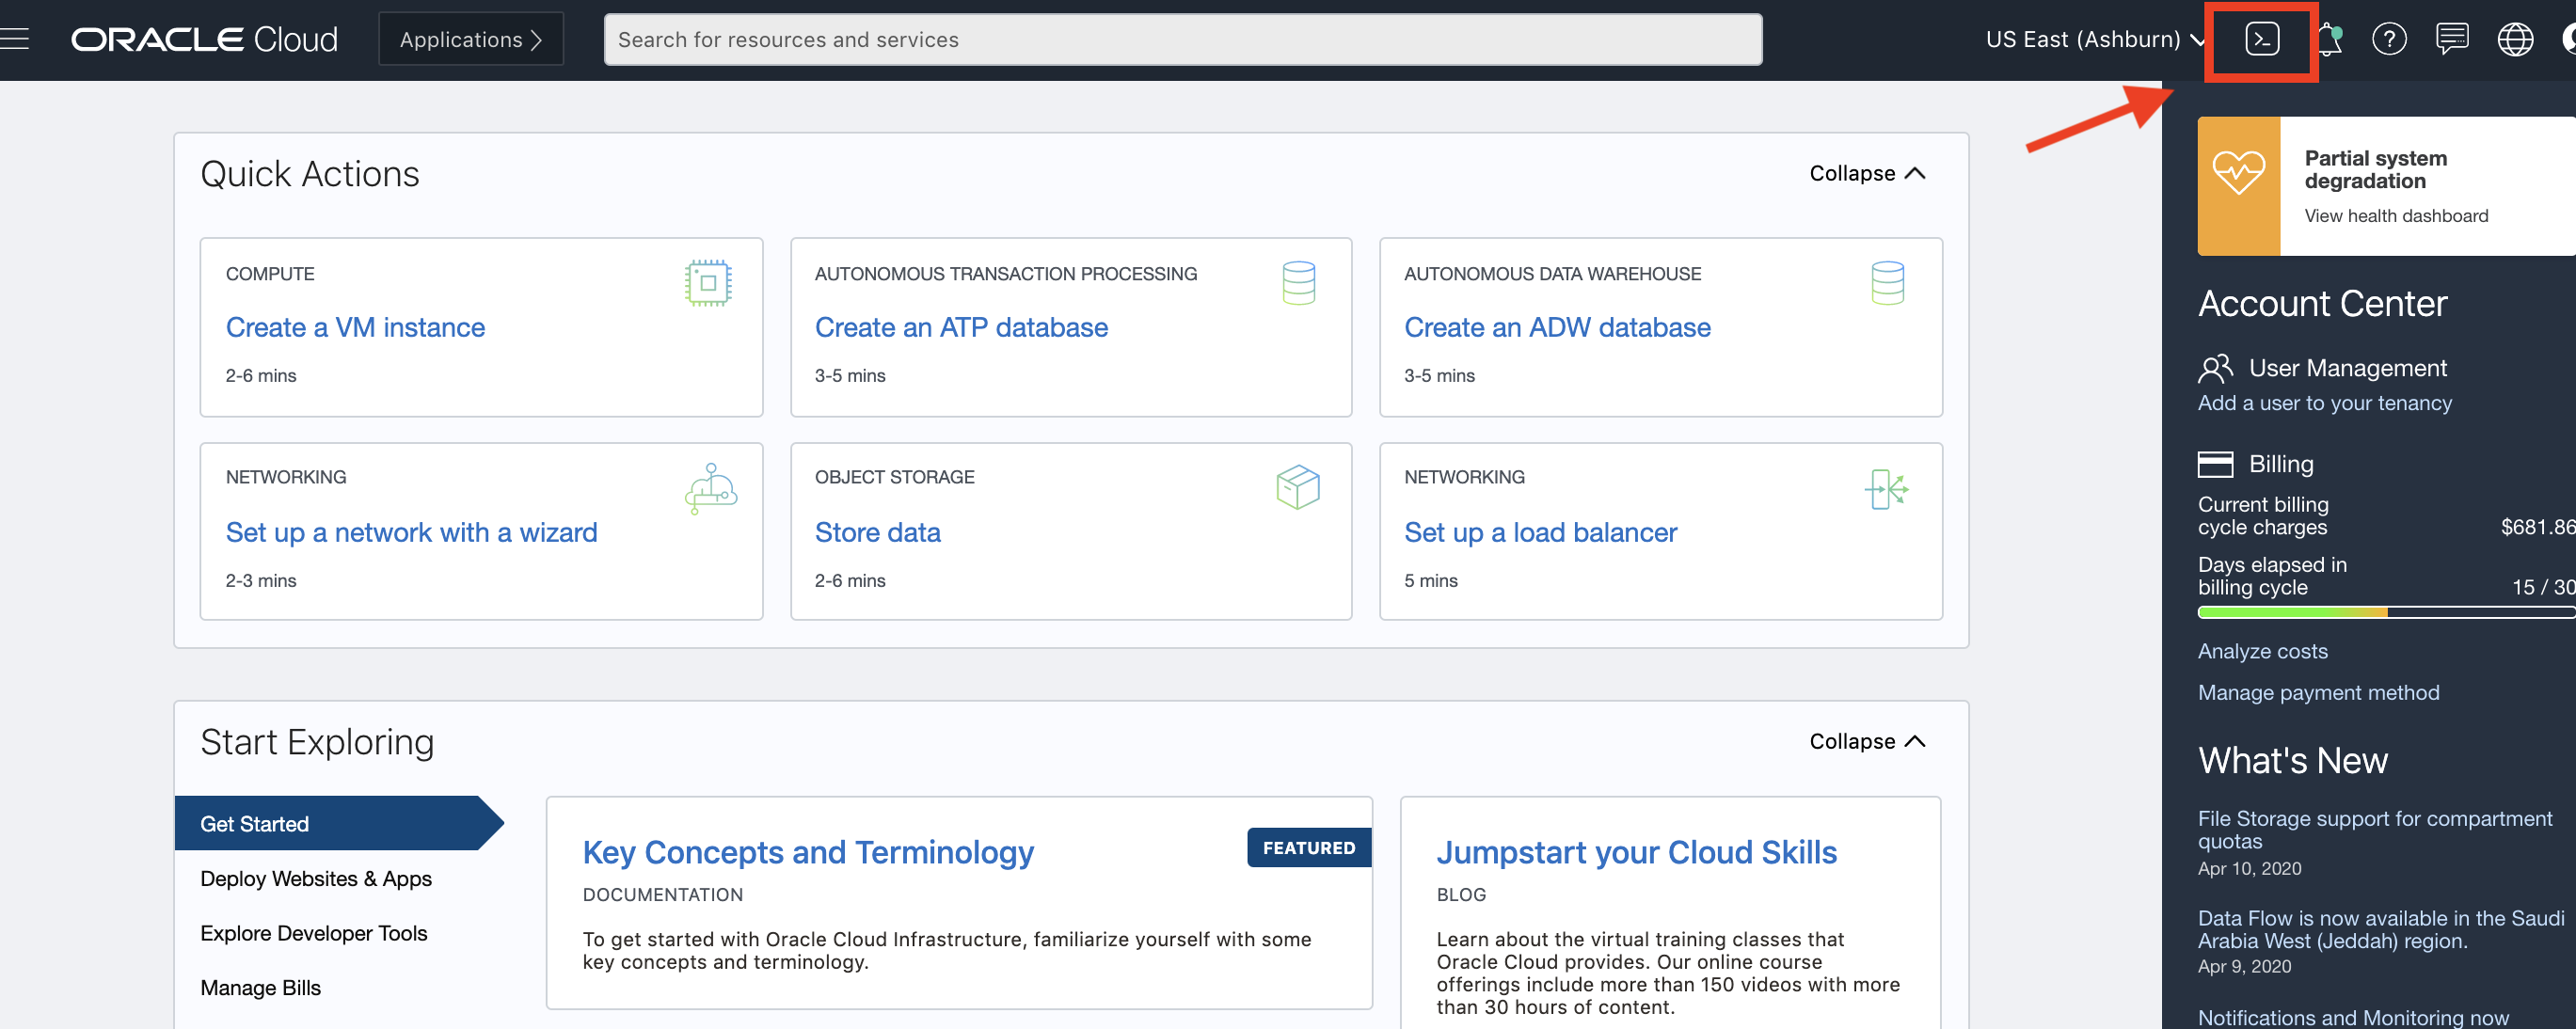

<a id='tenancy-setup'></a>
### Oracle Cloud Infrastructure Tenancy Setup  

Before deployment, an admin of your Oracle Cloud Infrastructure tenancy needs to setup the appropriate policies and give your Oracle Cloud Infrastructure user access to a compartment where the `Function` can be deployed. The Oracle Functions team has provided a very easy to use onboarding guide that lays out all the steps involved in setting up the tenancy for `Functions`. You can find it [here](https://www.oracle.com/webfolder/technetwork/tutorials/infographics/oci_functions_cloudshell_quickview/functions_quickview_top/functions_quickview/index.html#). This guide will help you: 

* create groups and users 
* create compartment for `Functions` 
* create VCN and subnets 
* create policies for user groups and Oracle Functions. 

We recommend you also read the section [Configuring Your Tenancy for Function Development](https://docs.cloud.oracle.com/iaas/Content/Functions/Tasks/functionsconfiguringtenancies.htm)

<a id='download-model-artifact'></a>
### Download the model artifact in Cloud Shell

After you open Cloud Shell, create a folder that you want to download the model artifact. Then go to that directory and run
```
oci data-science model get-artifact-content -–model-id <model_ocid> --file <downloaded_artifact_file.zip>

```

and then unzip the downloaded artifact file. 

```
unzip <downloaded_artifact_file.zip>

```

`<downloaded_artifact_file.zip>` is what you want to name the downloaded artifact zip file. And `<model_ocid>` can be found from the Oracle Cloud Infrastructure console as shown below, or by listing models in the model catalog. For additional information on the model catalog, please refer to the example notebook `model_catalog.ipynb`.

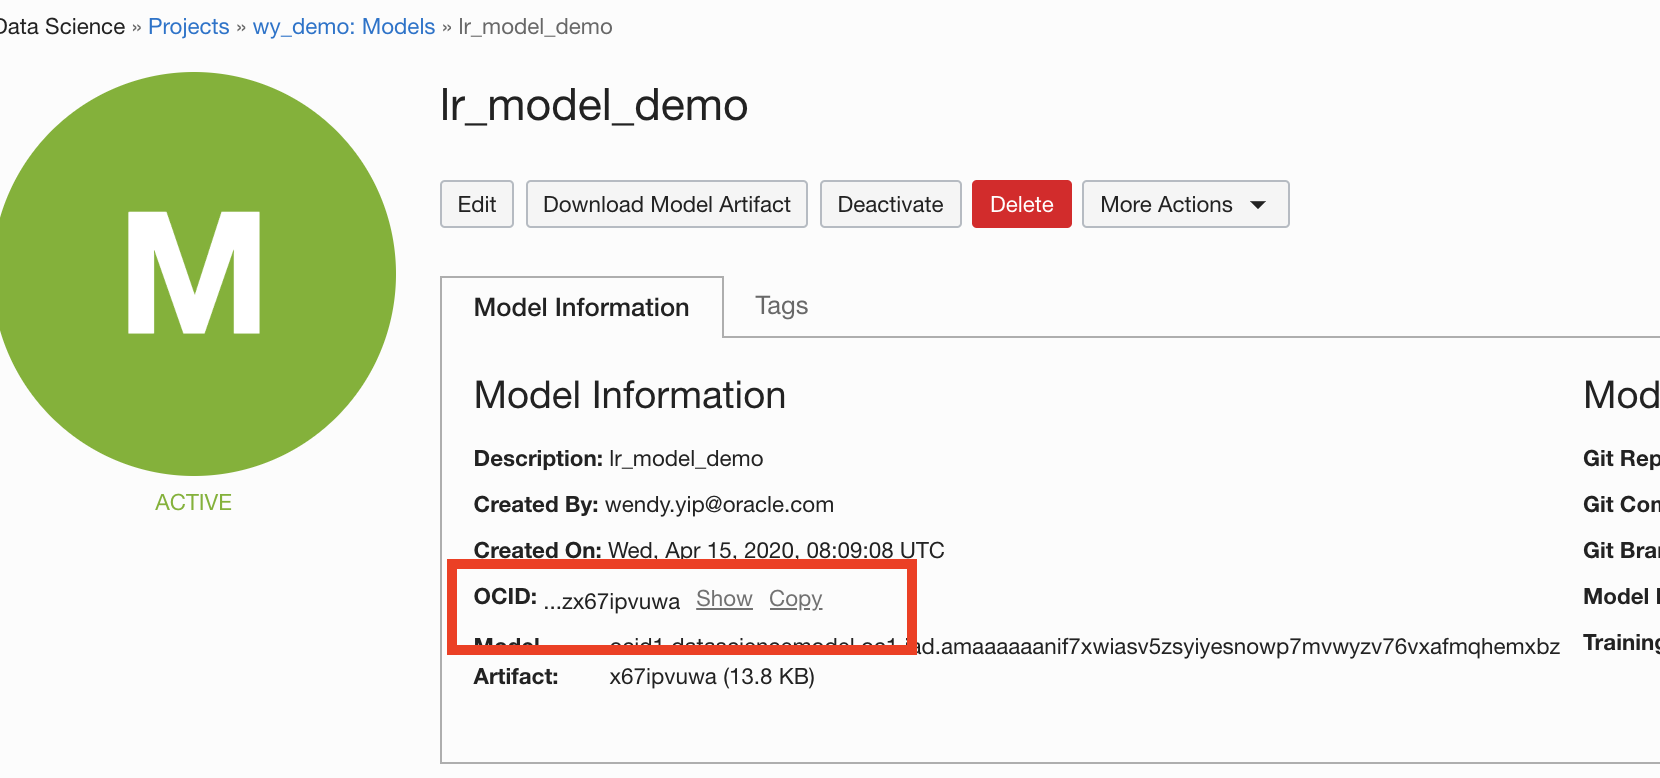

<a id='set-up-fn-cli'></a>
### Set up fn CLI on Cloud Shell

1) Create an application

Log into the Oracle Cloud Infrastructure Console page, in the tenancy and region where you want to host your function. Go to *Developers Services*, then go to *Functions*.  Create an Application. Select the vcn and subnet you have created for your Functions. 

<br/>


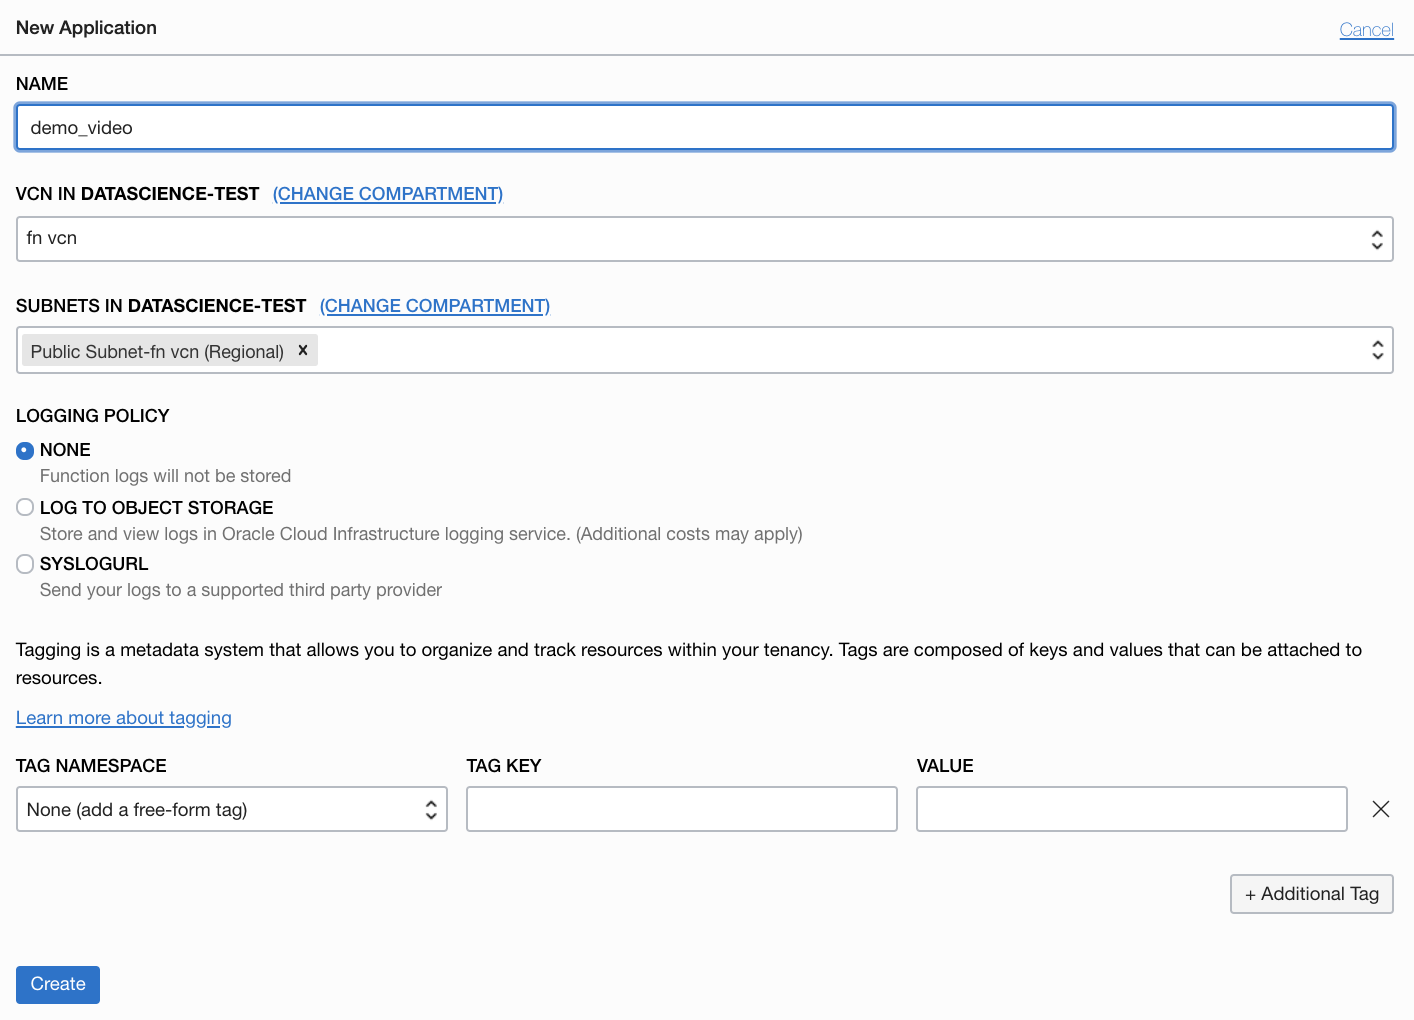

2) Select Cloud Shell Setup

You will see the list of Application that have created.  Click on the name of the Application you want to use.  Then, click on the Getting Started tab and choose the Cloud Shell Setup option.  After you have selected the option, you will see a list of step-by-step instruction on how the set up the fn CLI, along with commands that you can copy and paste into your Cloud Shell terminal to set up the CLI.

<br/>

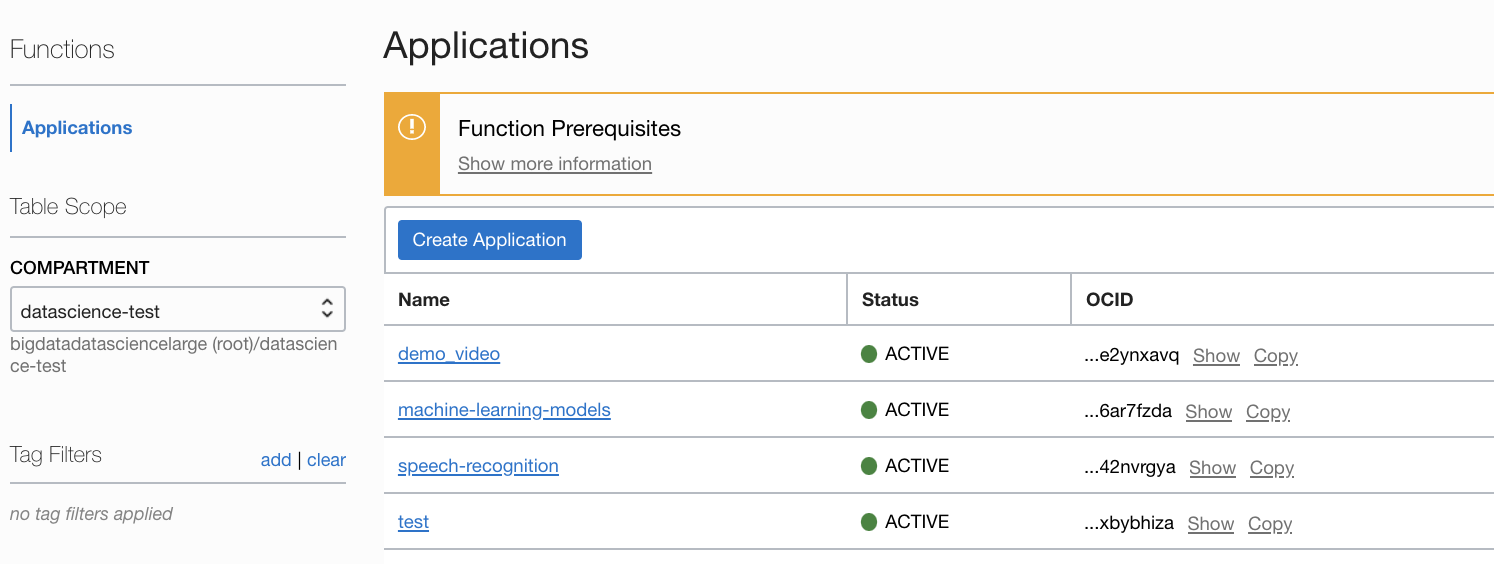

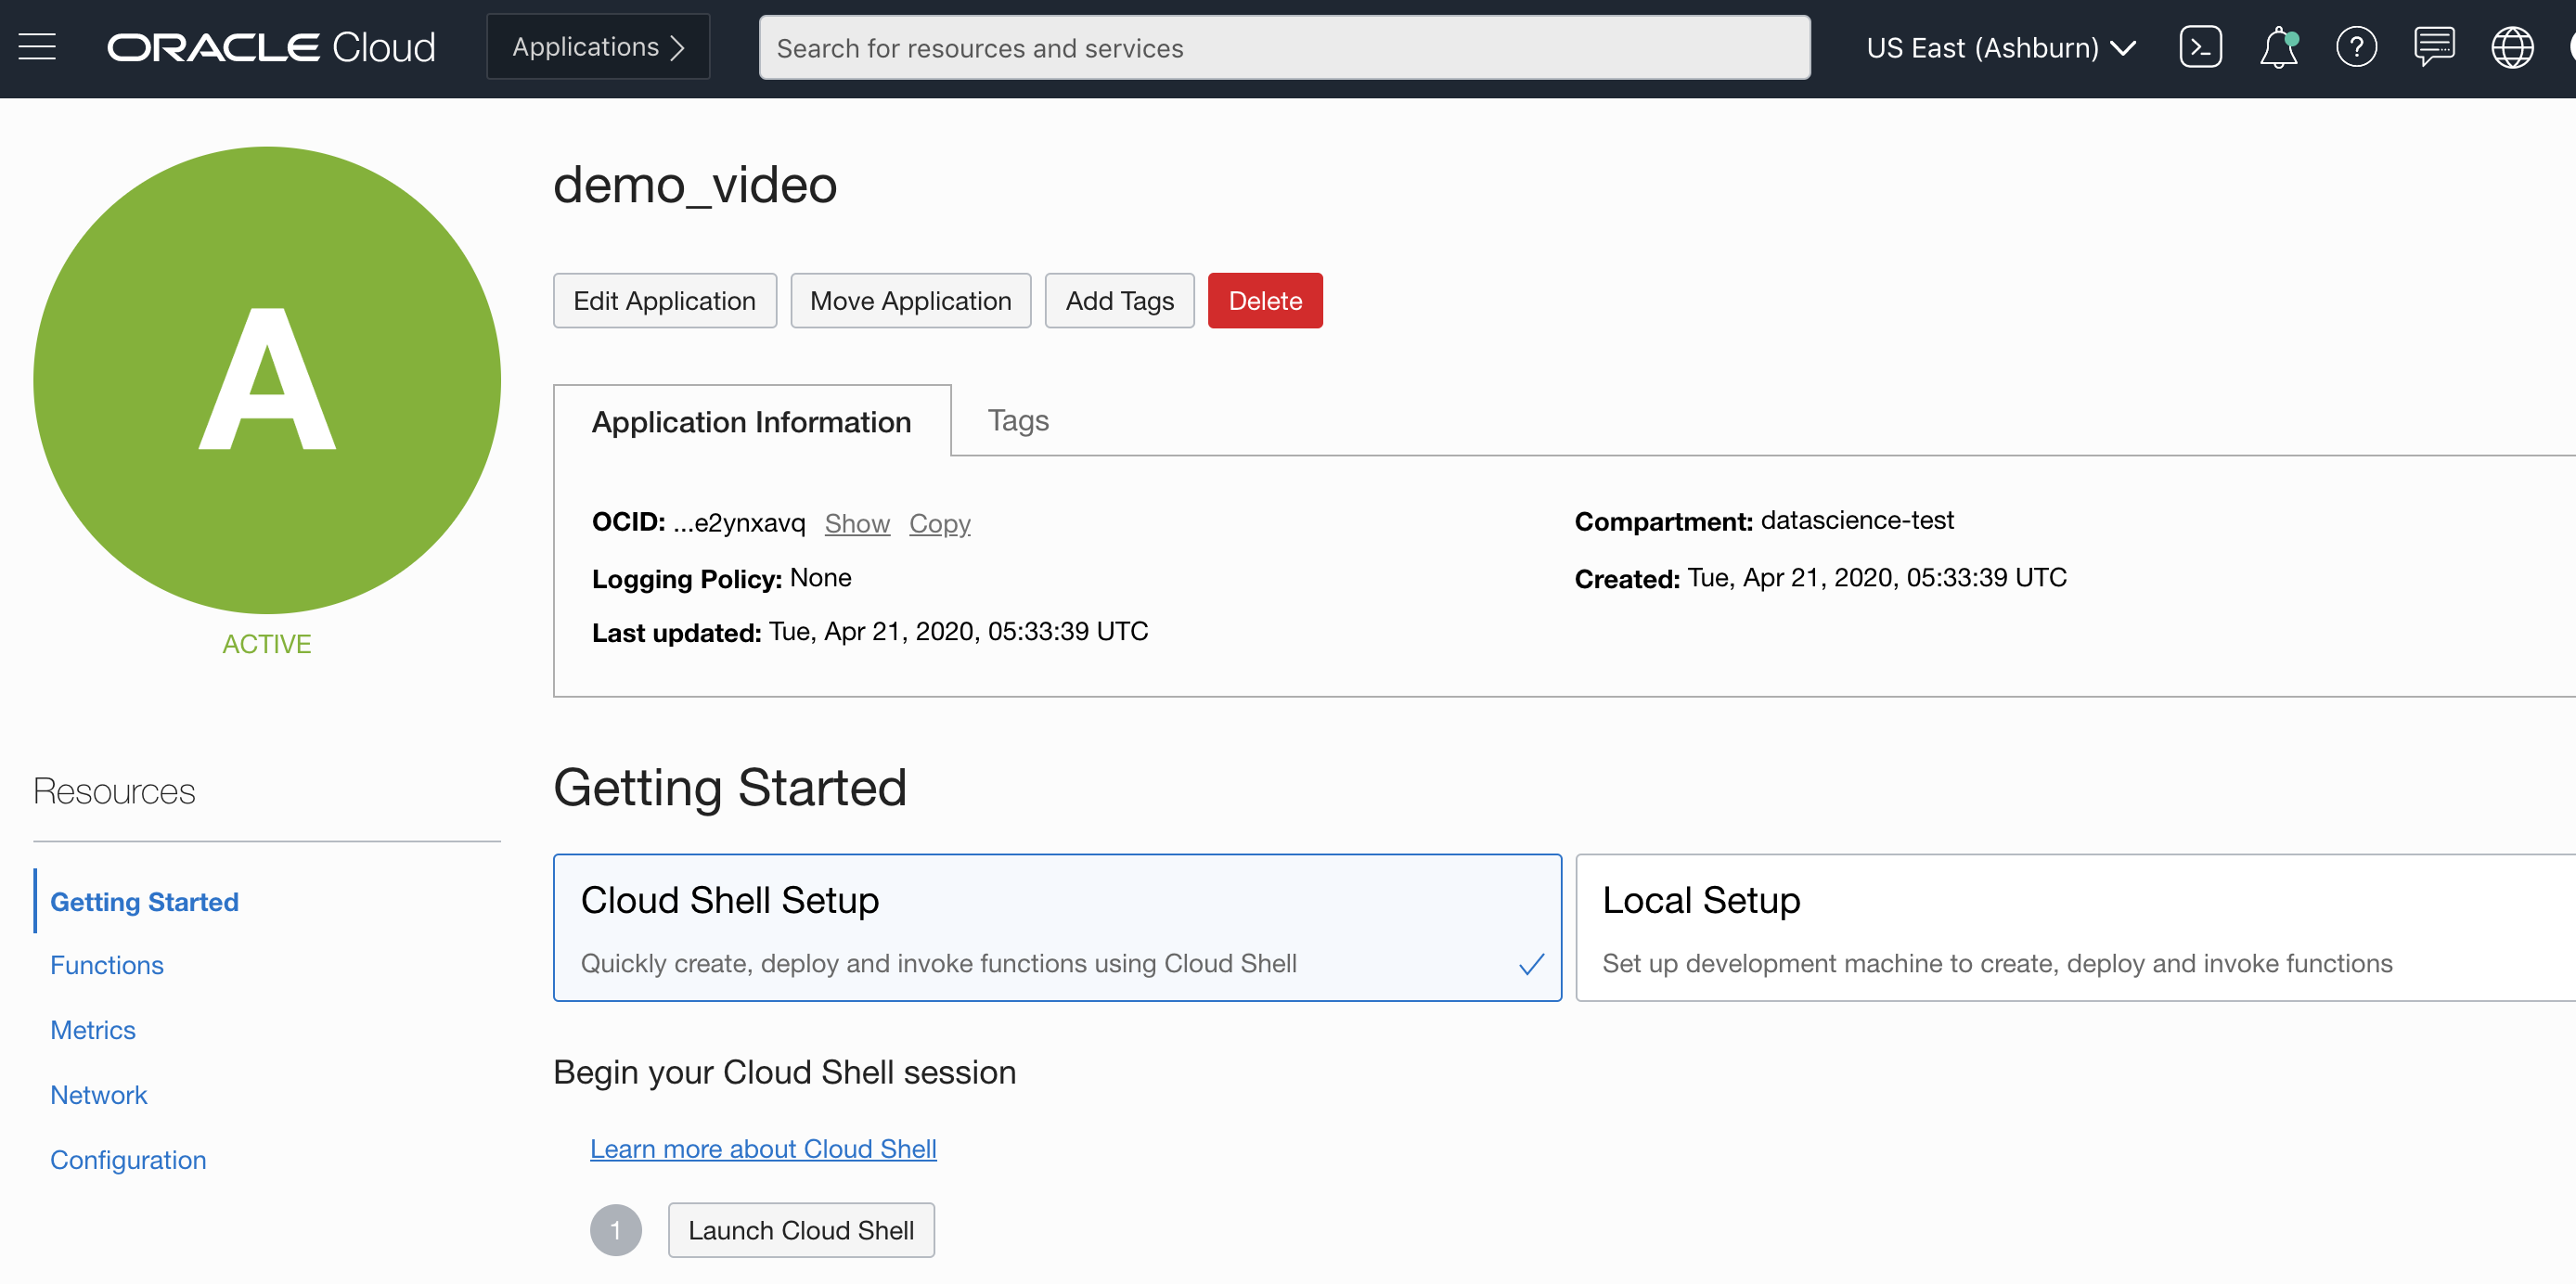

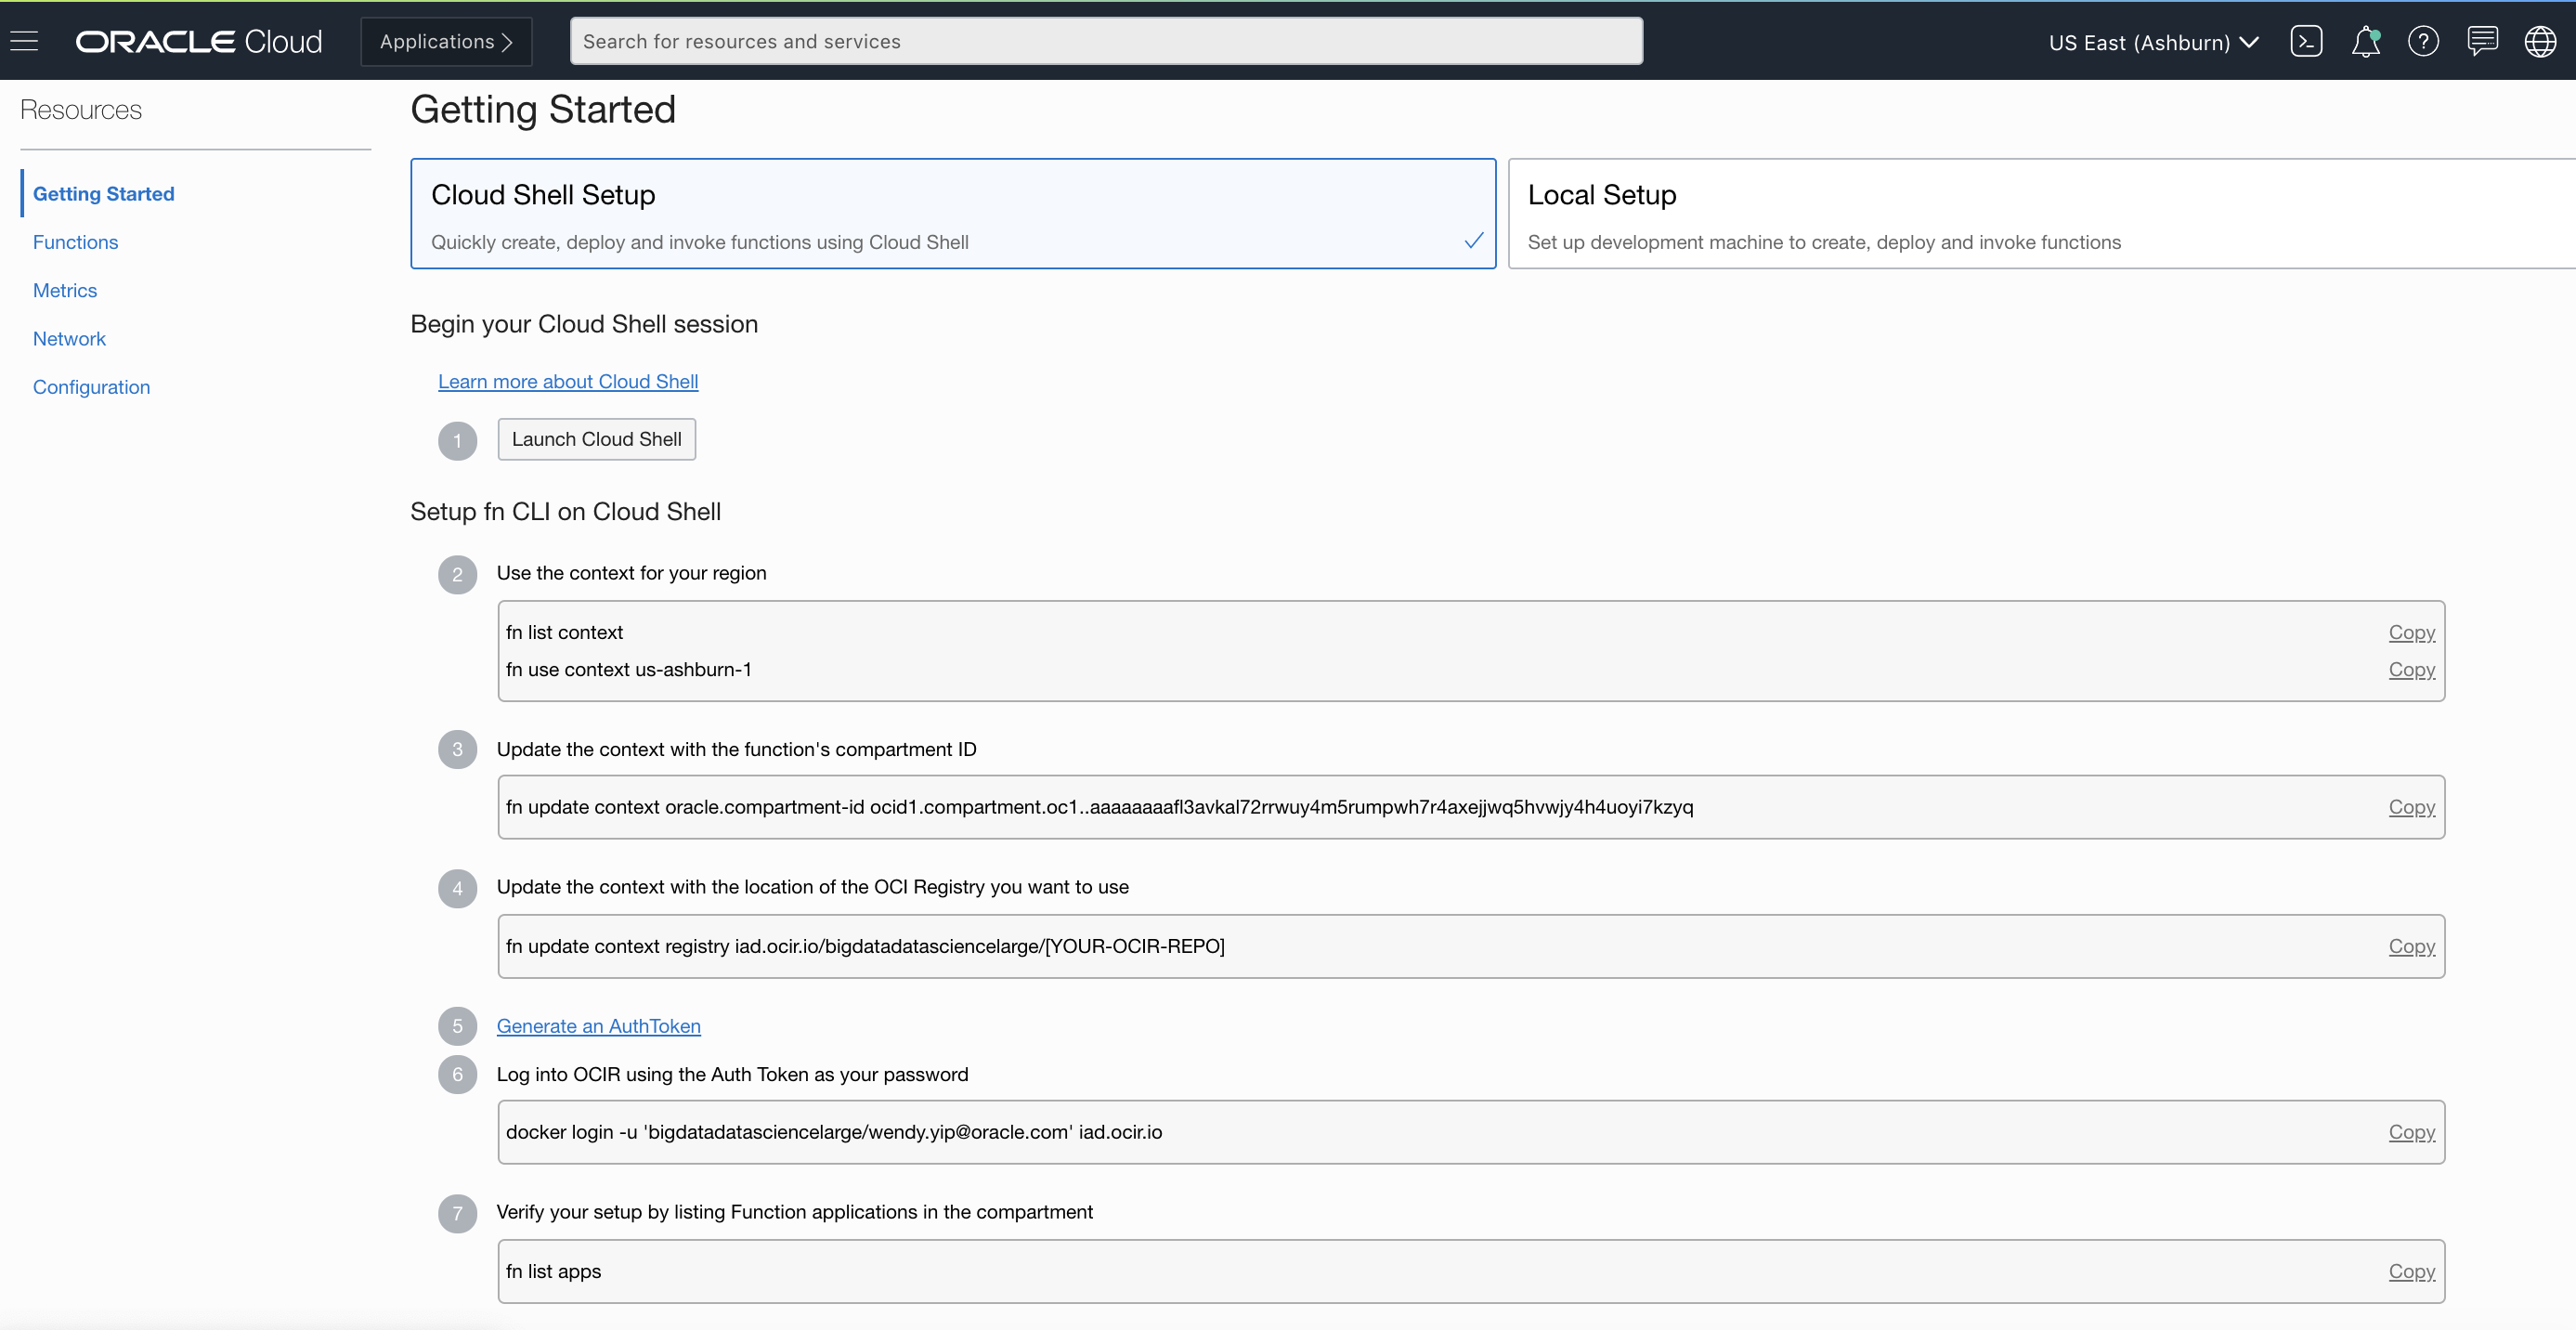



3) Use the context for your region


In your Cloud Shell terminal, you can find out the context available to you using the command 
```
fn list context
```
Use the context for your region.  In the setup instruction, your oci region name is already populated in the instruction command.  You can simply copy and paste the command into your terminal.

```
fn use context <oci-region-name>
```

</br>
4) Update the context with the compartment id you want to use to deploy your Function.  The compartment id of the compartment you are currently using will be populated in the instruction 


```
fn update context oracle.compartment-id <compartment-ocid>

```
</br>

5) Update the context with the location of the Oracle Cloud Infrastructure Registry you want to use 


```
fn update context registry <region-key>.ocir.io/<objet-store-namespace>/<repo-name>

```

Your `<object-store-namespace>` and `<region-key>` are populated in the command in the step-by-step instruction.  `<repo-name>` is the repository name you want to push your image to. You can specify the name of the repo you want to use.  If the repo has not yet been created, it will be created for you after executing the command.  

`<object-store-namespace>` is the auto-generated Object Storage namespace string of the tenancy where your repositories are created (as shown on the Oracle Cloud Infrastructure Tenancy Information page).

`<region-key>` is the key of the Oracle Cloud Infrastructure Registry region where your repositories are created. For example, `<region-key>` for `us-ashburn-1` is `iad`. 

</br>

6) Generate an AuthToken to enable login to Oracle Cloud Infrastructure Registry

You need to create an auth token to enable login to Registry (OCIR). The link to create the token is in the step-by-step instruction.  You can visit this [link](https://docs.cloud.oracle.com/en-us/iaas/Content/Functions/Tasks/functionsgenerateauthtokens.htm) for additional information about auth token.

</br>

7) Log into OCIR using the Auth Token as your password


```
docker login -u ‘object-store-namespace/user-name’ region-key.ocir.io

```
The object storage namespace, user-name and region-key are already populated in the instruction command.

When prompted to enter the password, use the Auth Token you have generated.

<a id='create-deploy-invoke-functions'></a>
### Create, Deploy and Invoke Functions

8) Deploy your `Function` 

Go inside the model-artifact folder. You will use the `deploy` command which will build your image, push it to the repo in OCIR and deploy the `Function` 

```
fn --verbose deploy --app <my-app>
```

9) Invoke your `Function` 

You can pass a JSON payload to your `Function` (remember to use the `input` convention described above) using a simple `cat` command. For example below we pass a list of feature vectors stored in the file `data-sample.json` to `<my-function>`. Do not forget to specify the content type which is `application/json` in most cases: 
```
cat data-sample.json | fn invoke <my-app> <my-function> --content-type application/json
```

Sample `data-sample.json`:
```json
{"input":[[0.9426354816951444,10.0,1.4691851561691212,-443.41377583633323,-0.01884418423666756,2.5156476289097847,-9.0,101.0,-9.0,-0.13569659843193554,1000.0, 10.0,0.0,0.0,1.4507967114096254,-43.87337348658269,0.0004781176582166312,3.0990946463672753,-4.668506323375299,-0.1549329356194024,19.421065136359413, 0.203789137870722,-0.0016150491614570614,2.8334756912076617,-0.004230294763510757,10.0,-1.0,16.602457994672683,1.8711181897376987,11.801446013761858, -1.5978704963512458,1.2148721218109126,-407.3669945970512,133.0075252989285,1.2262200162027341,100.0,8.001033298496045,-0.026874430938811675, 1.3678443110500578,1.7197167339866108,0.1435355464405037,1000.0,0.1954810896006457,0.05063792285779614,-2.428815607323977, -4.695494887609295, 109.86208050517756,157.98065903844312]]}
```

Sample output:
```javascript
{
    "prediction": [1.0]
}
```

You can inspect that the `Function` is packaged successfully with the app using `fn inspect` command

```
fn inspect function <my-app> <my-function>
```

<a id='api-gateway'></a>
## Using Oracle Functions as a Backend Source of the Oracle Cloud Infrastructure API Gateway 

### Set up Tenancy for API Gateway Development

Before using the API Gateway service to create API gateways and deploy APIs on them, you have to complete the following steps to set up your tenancy for API gateway development.

* Create groups and users to use API Gateway
* Create compartments to own network resources and API Gateway resources in the tenancy
* Create a VCN to use with API Gateway 
* Create policies to control access to network and API Gateway-related resources</a>

More detailed information can be found in [Preparing for API Gateway](https://docs.cloud.oracle.com/en-us/iaas/Content/APIGateway/Concepts/apigatewayprerequisites.htm) and [Configuring Your Tenancy for API Gateway Development](https://docs.cloud.oracle.com/en-us/iaas/Content/APIGateway/Tasks/apigatewayconfiguringtenancies.htm).

<a id='appendix-II-groups'></a>
#### Create groups and users to use API Gateway

From the OCI console, under Governance and Administration go to Identity/Groups, create a new group called `api_gateway_developers_group`.

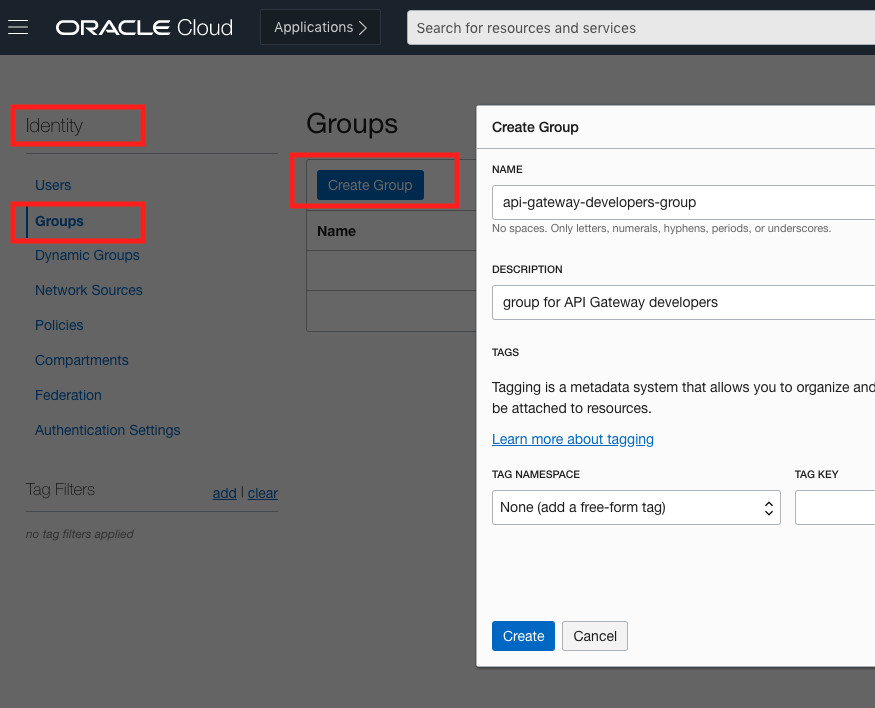

<a id='appendix-II-policies'></a>
#### Create Policies to Control Access to Network and API Gateway-Related Resources

From the Oracle Cloud Infrastructure console, under Governance and Administration go to Identity/Policies, select the compartment that will own API Gateway-related resources from the list on the left and click `Create Policy`.

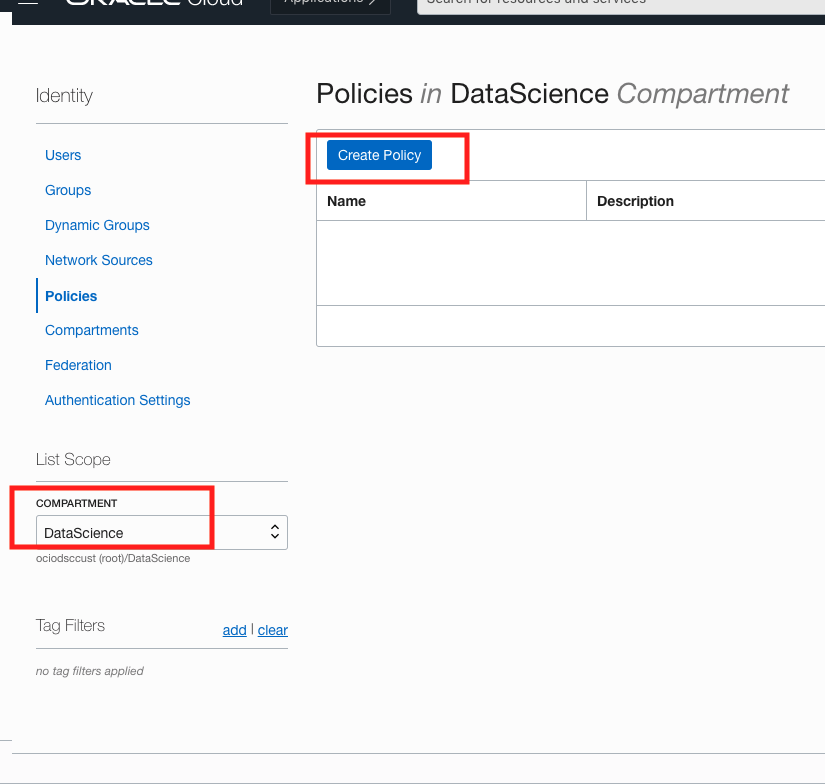

1) Create a Policy to Give API Gateway Users Access to API Gateway-Related Resources

Enter a meaningful name for the policy and under `Policy Statements` as Statement 1, enter the following policy statement to give the group access to all API Gateway-related resources in the compartment:

`Allow group <group-name> to manage api-gateway-family in compartment <compartment-name>`

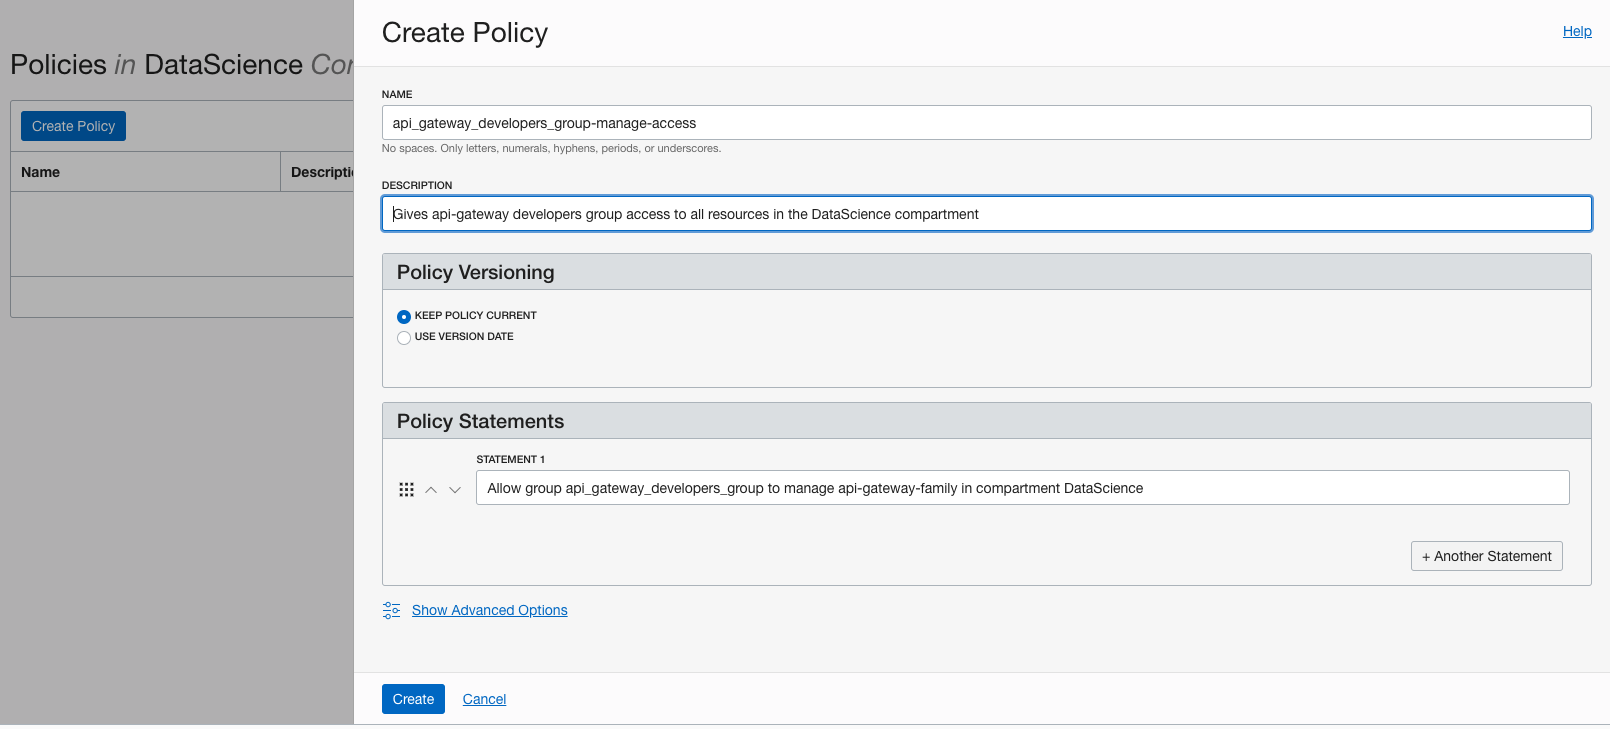

2) Create a Policy to Give API Gateway Users Access to Network Resources

Enter a meaningful name for the policy and under `Policy Statements`, enter the following policy statement to give the group access to network resources in the compartment (including the ability to manage public IP addresses):

`Allow group <group-name> to manage virtual-network-family in compartment <compartment-name>`

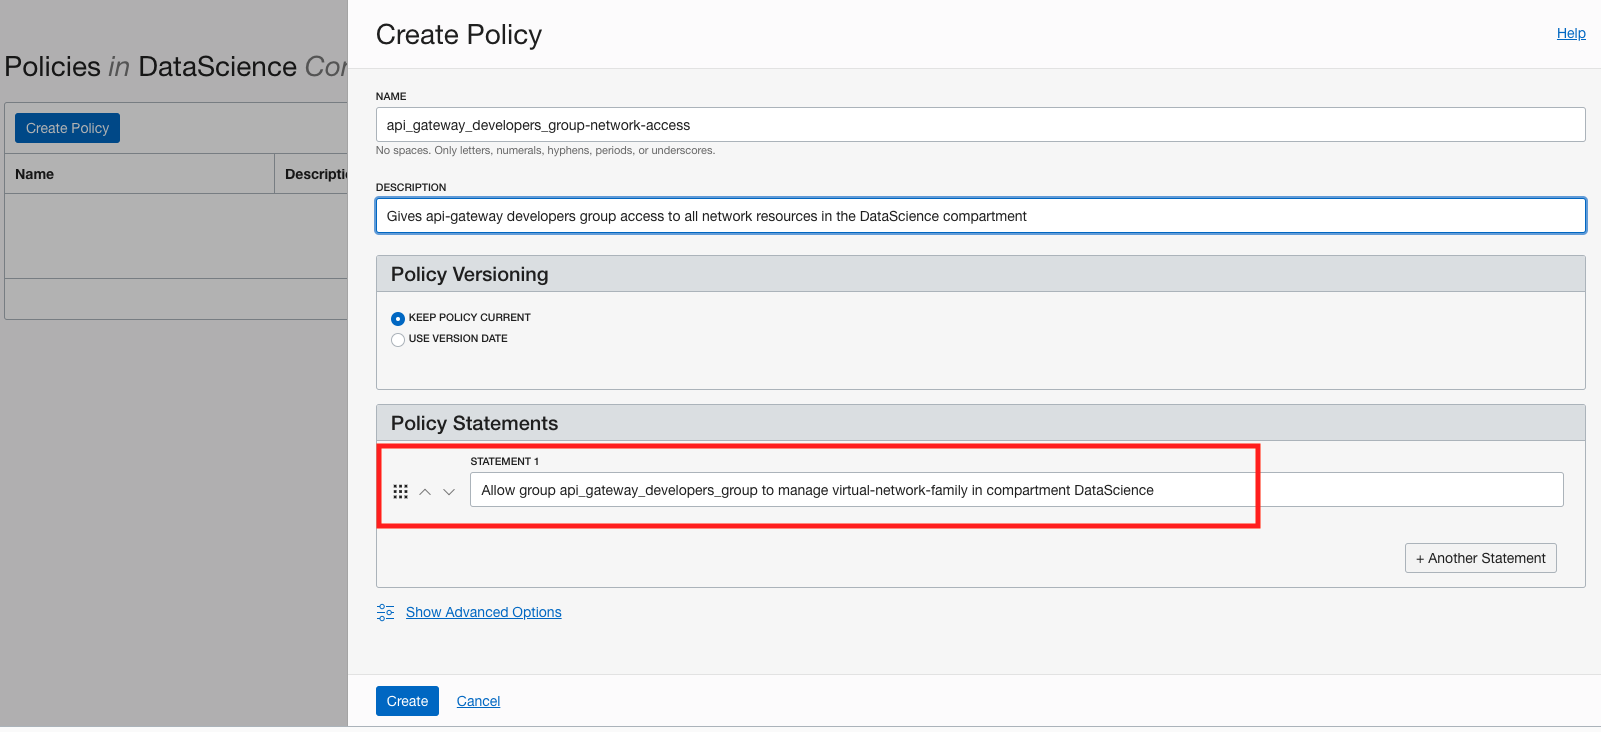

3) Create a Policy to Give API Gateway Users Access to Functions

Enter a meaningful name for the policy and under `Policy Statements`, enter the following policy statement to give the group access to the functions in the compartment:

`Allow group <group-name> to use functions-family in compartment <compartment-name>`

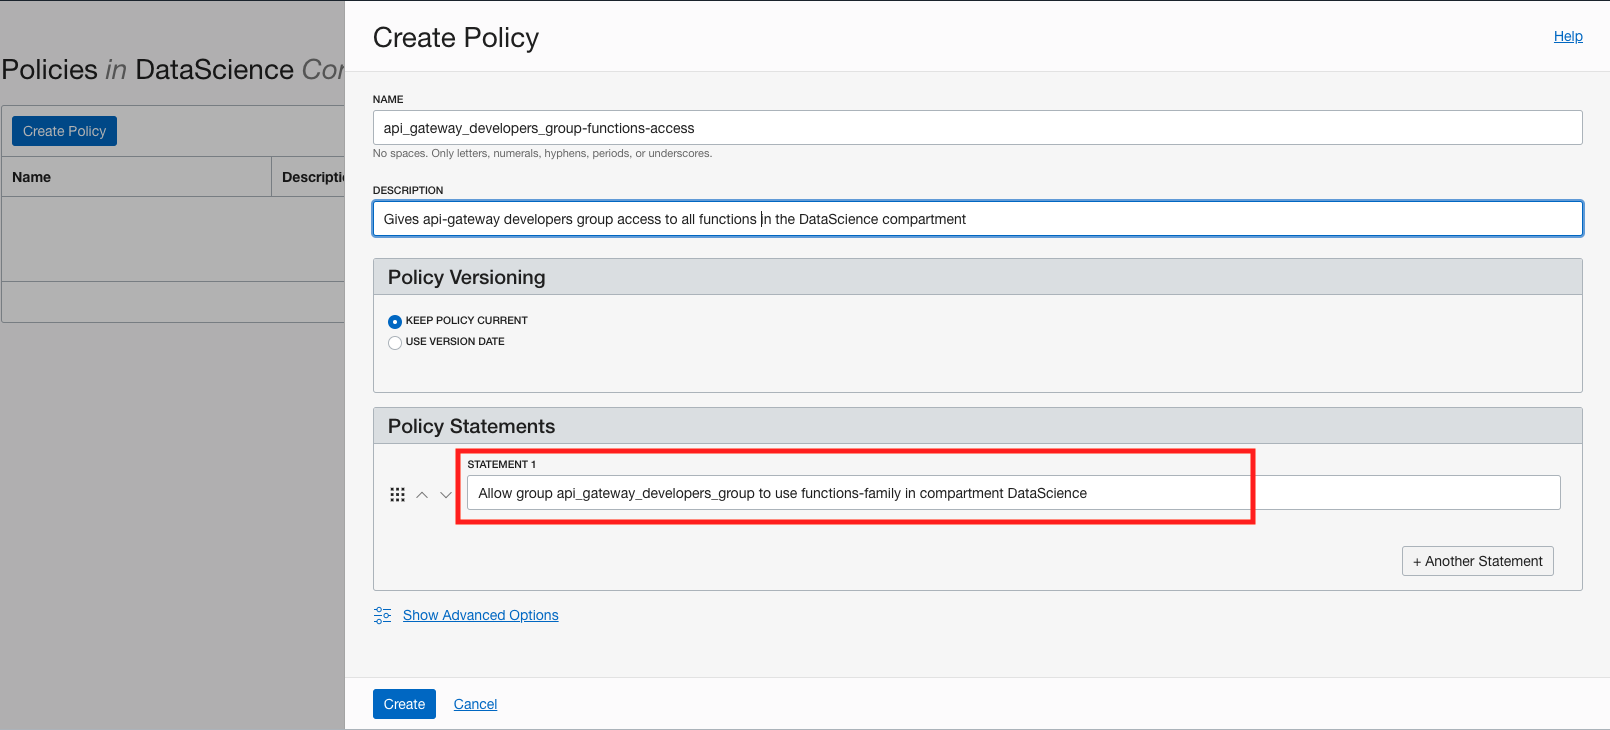

4) Create a Policy to Give API Gateways Access to Functions

Enter a meaningful name for the policy and under `Policy Statements`, enter the following policy statement to give the group access to the functions in the compartment:

`ALLOW any-user to use functions-family in compartment <functions-compartment-name> 
where 
ALL { request.principal.type= 'ApiGateway' , 
      request.resource.compartment.id = '<api-gateway-compartment-OCID>' 
}`


Please note that `<functions-compartment-name>` is the name of the compartment containing the functions you want to use as back ends for API gateways and `<api-gateway-compartment-OCID>` is the OCID of the compartment containing the API gateways that you want to have access to the functions.

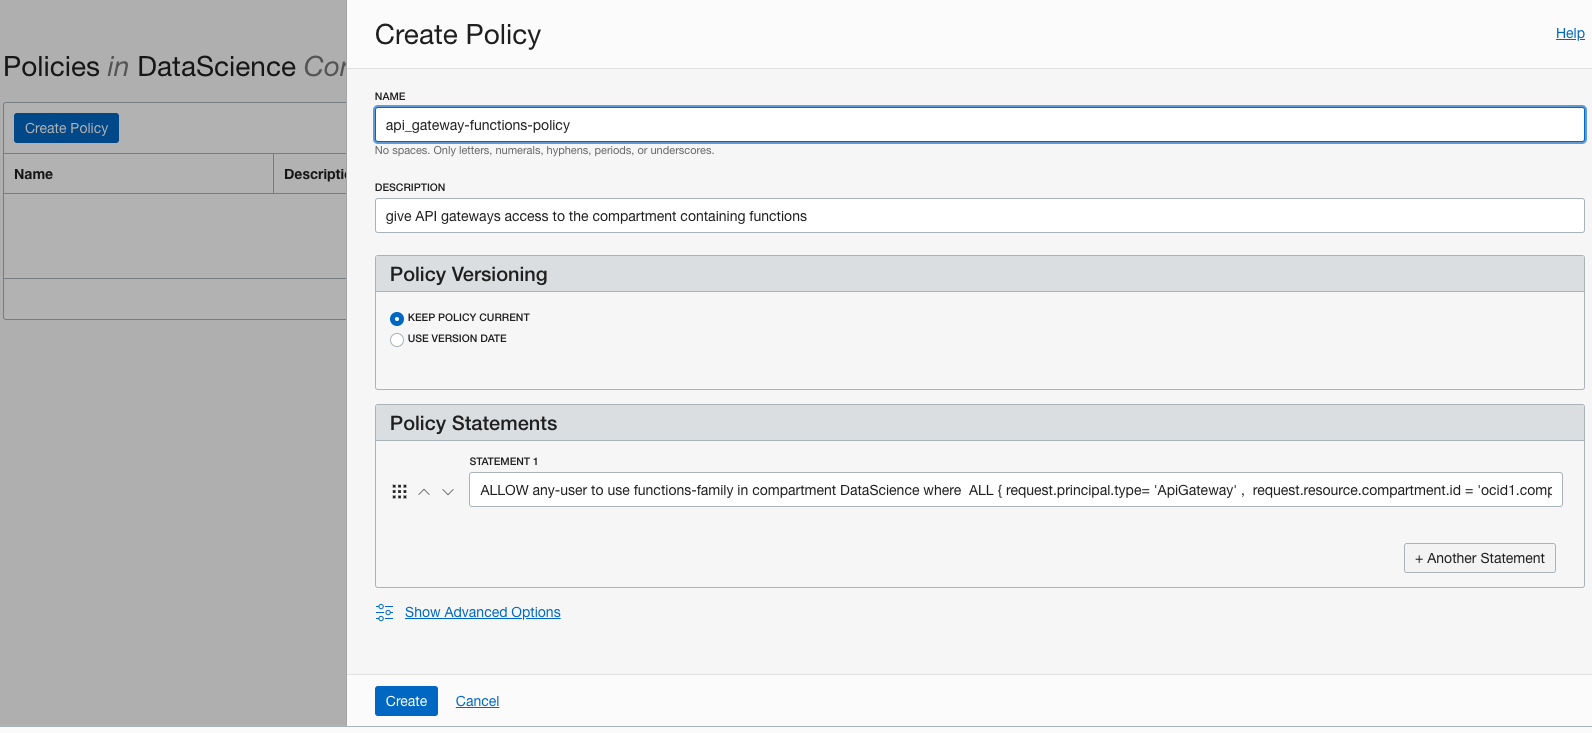

### Creating an API Gateway

From the OCI console under `Developer Services/API Gateway`, click `Create Gateway`.  Enter the name of the compartment you want to use for the API Gatway and the VCN and subnet.

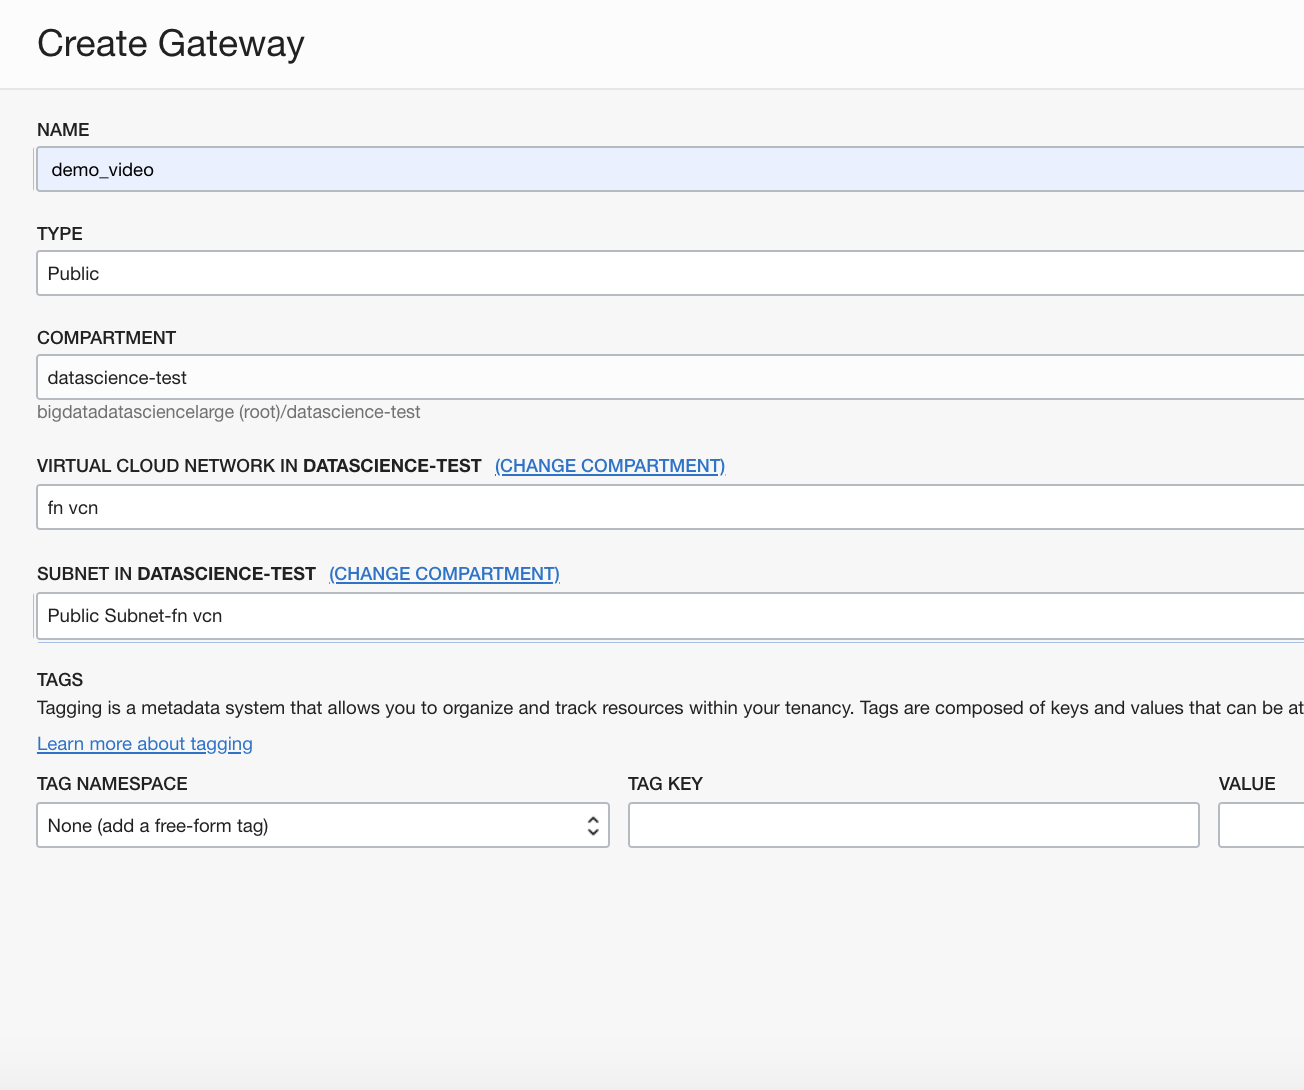

### Deploying Your Function as a Backend to API Gateway 

1)	From Developer Services/API Gateway menu in the Oracle Cloud Infrastructure Console,  select the compartment containing your API Gateway. 

Click on the created gateway. Select `Deployments` from left menu, then click `Create Deployment`

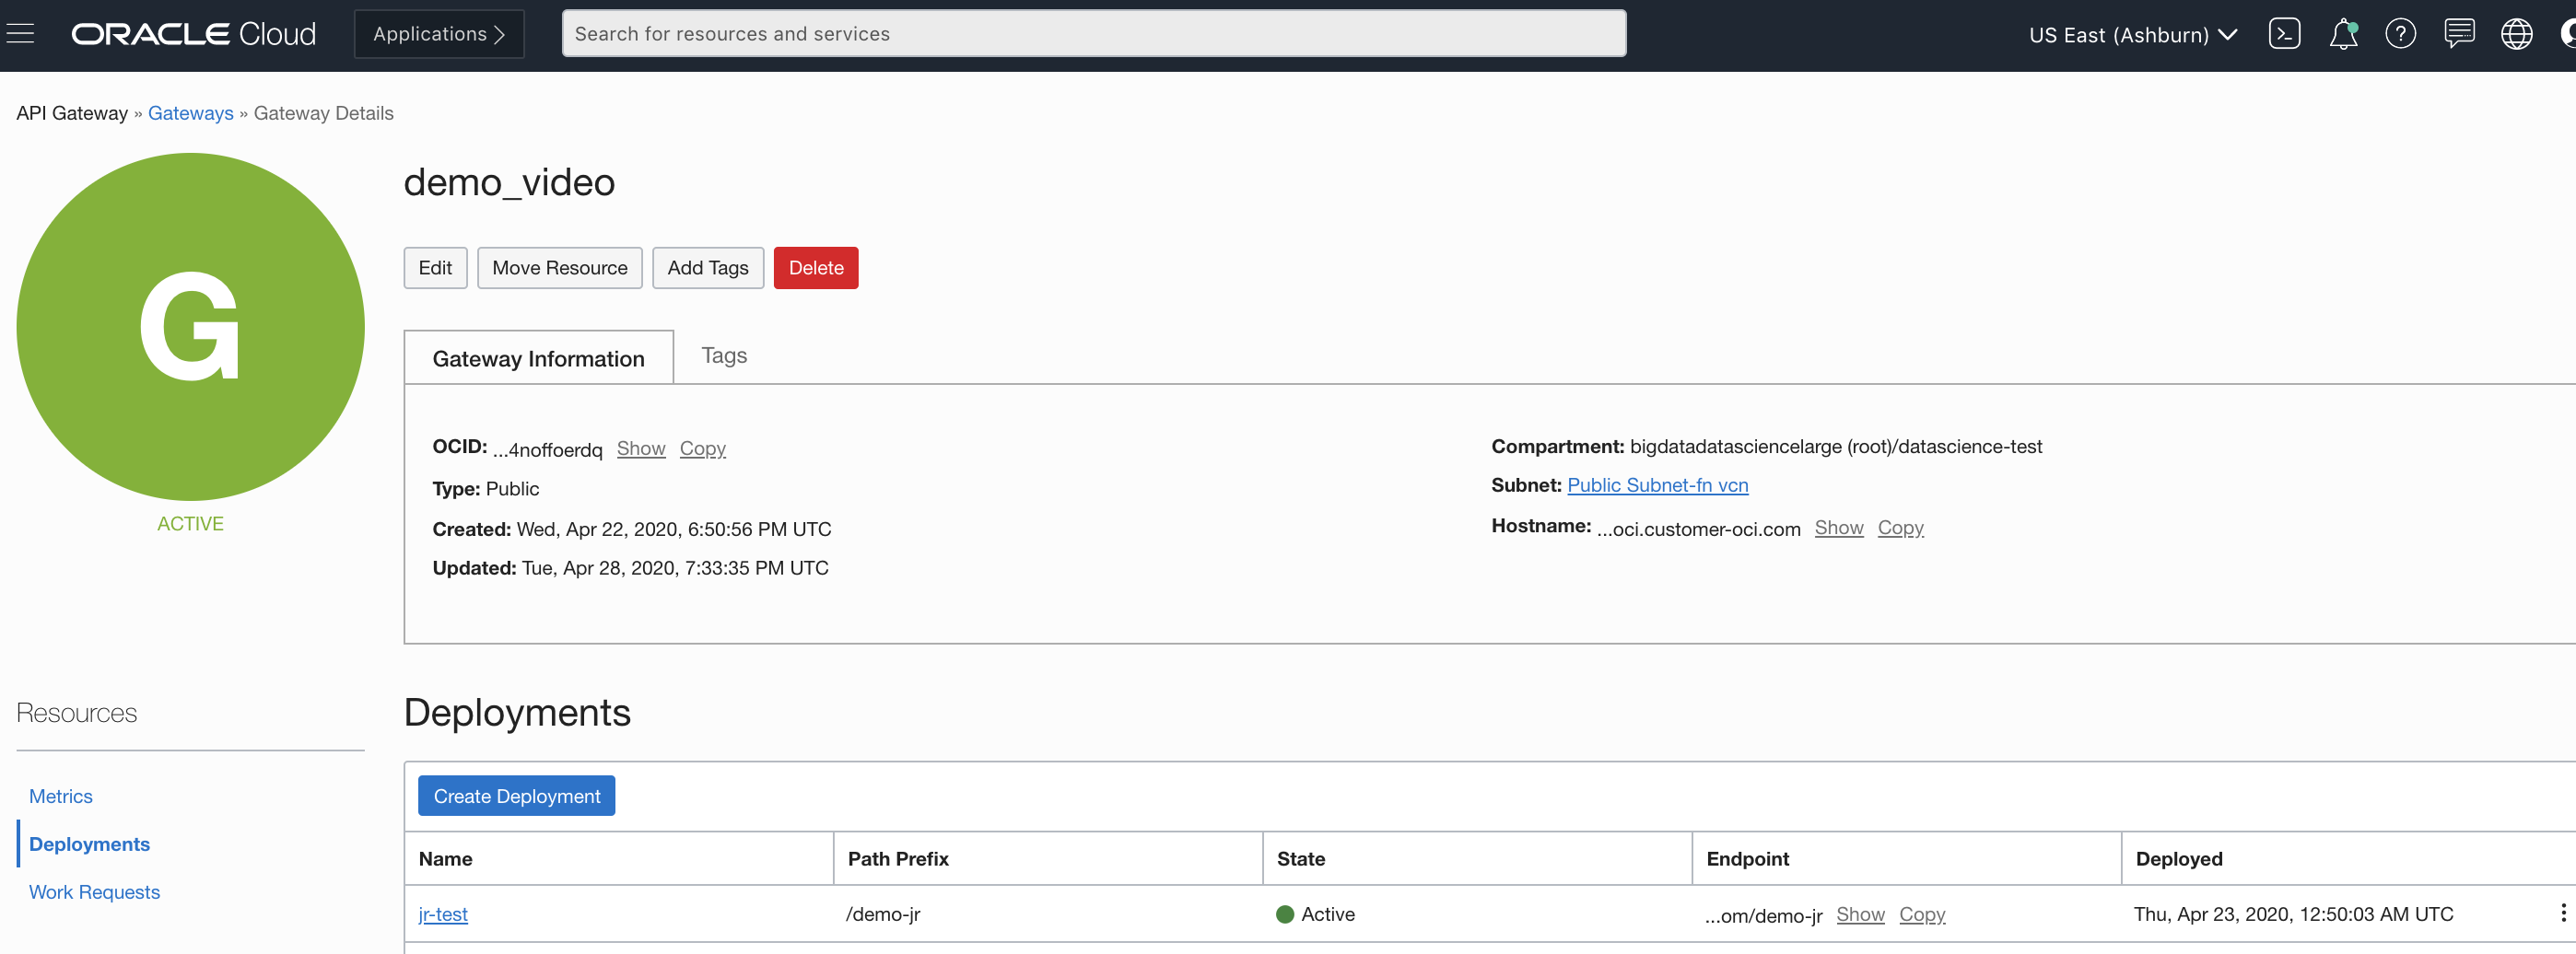

2)	Specify the `Name`, `Path Prefix`, and `Compartment` of your API. Then click `Next`

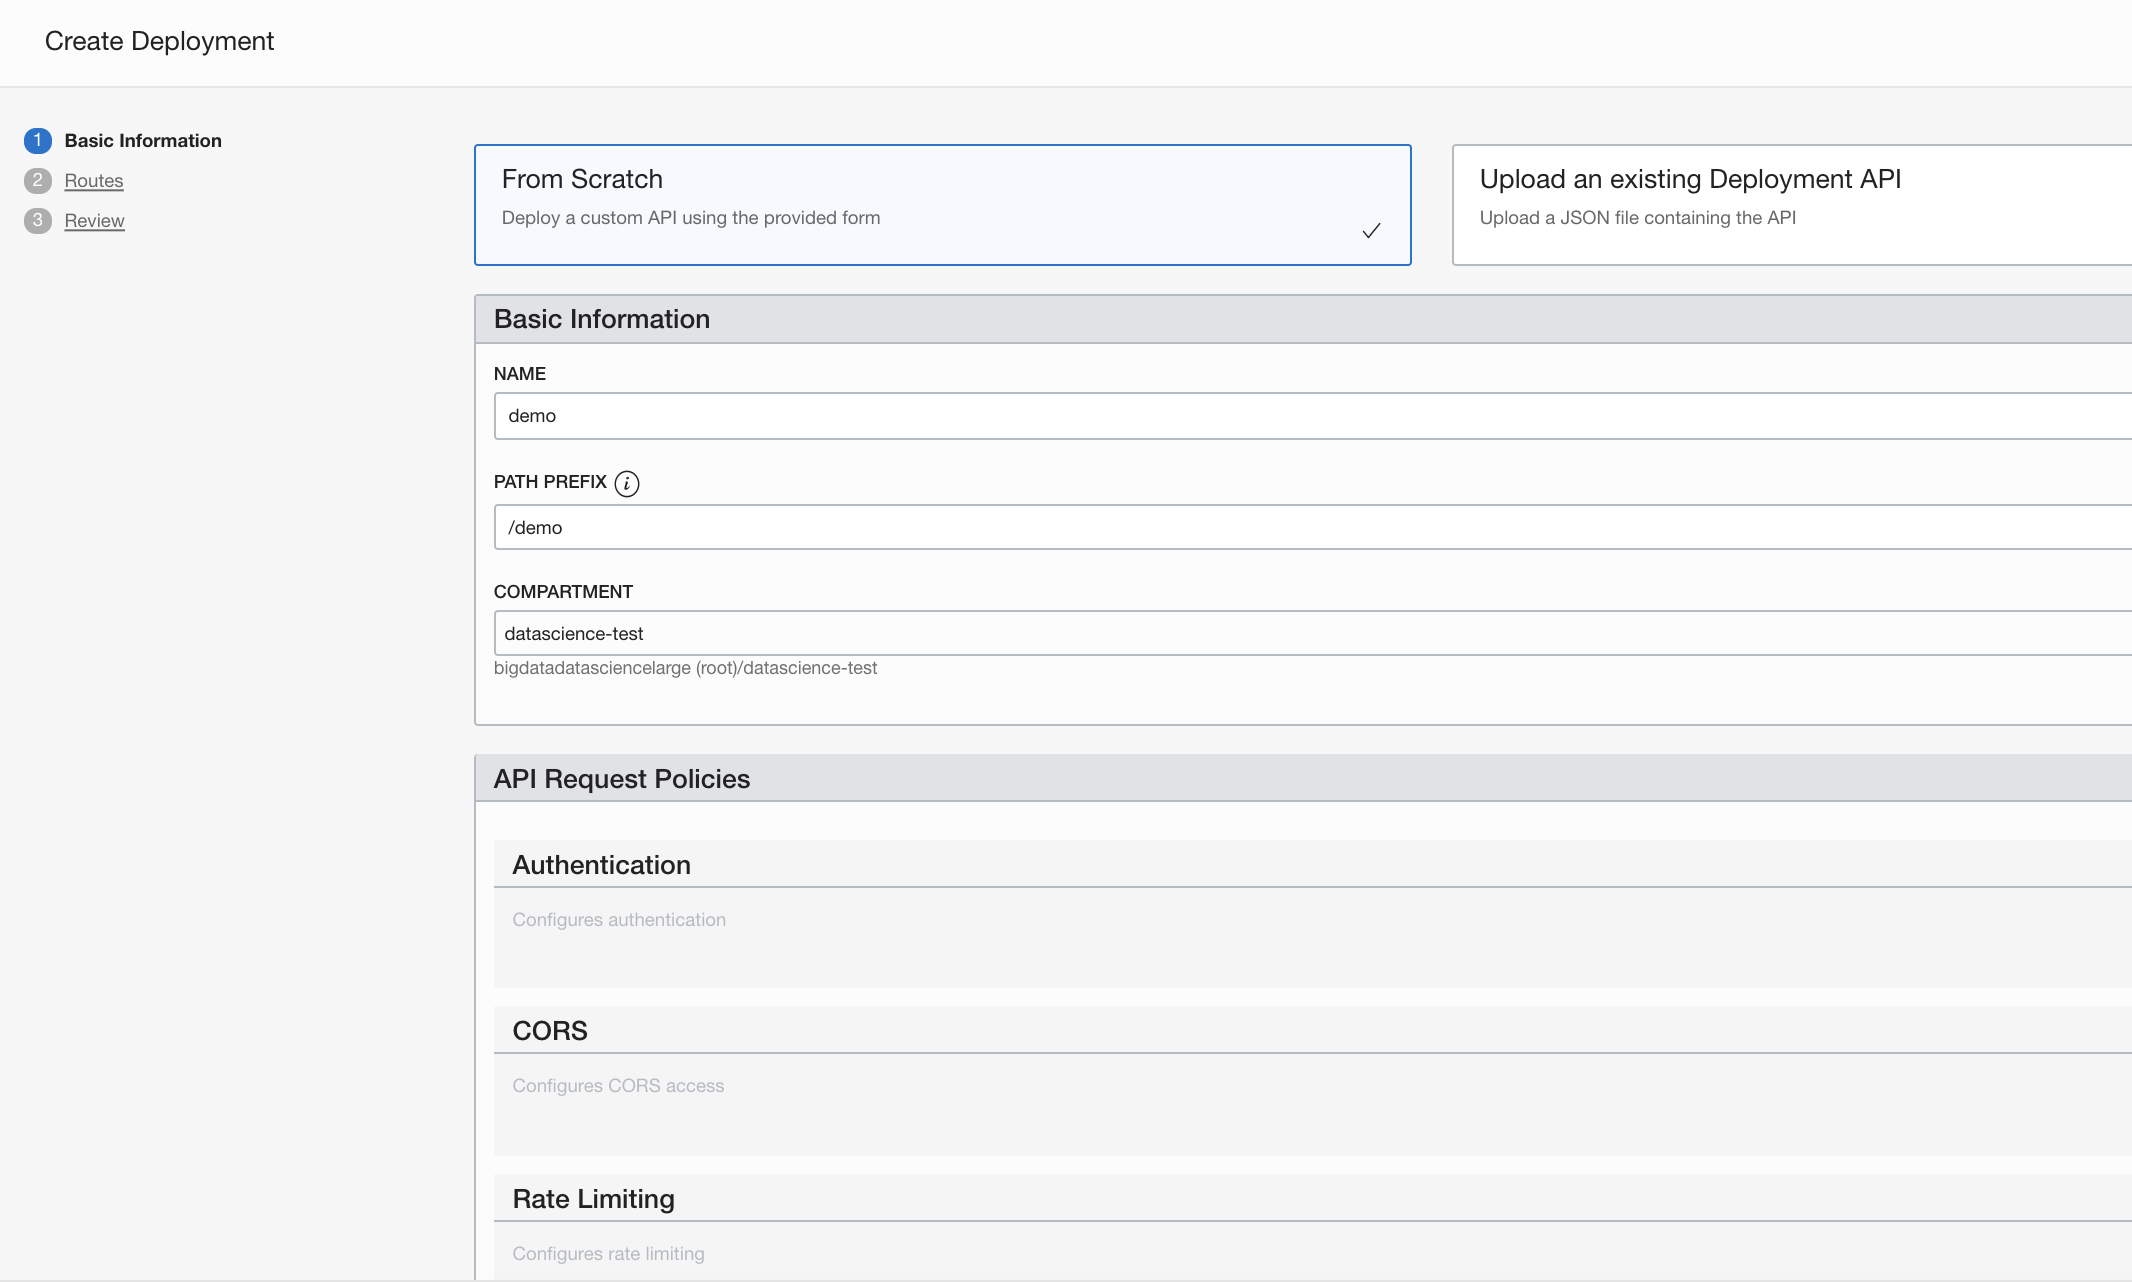

3)	Select your `Function Application` and the `Function`. Specify an `HTTP METHOD` and endpoint root. Click `Next` then `Create`

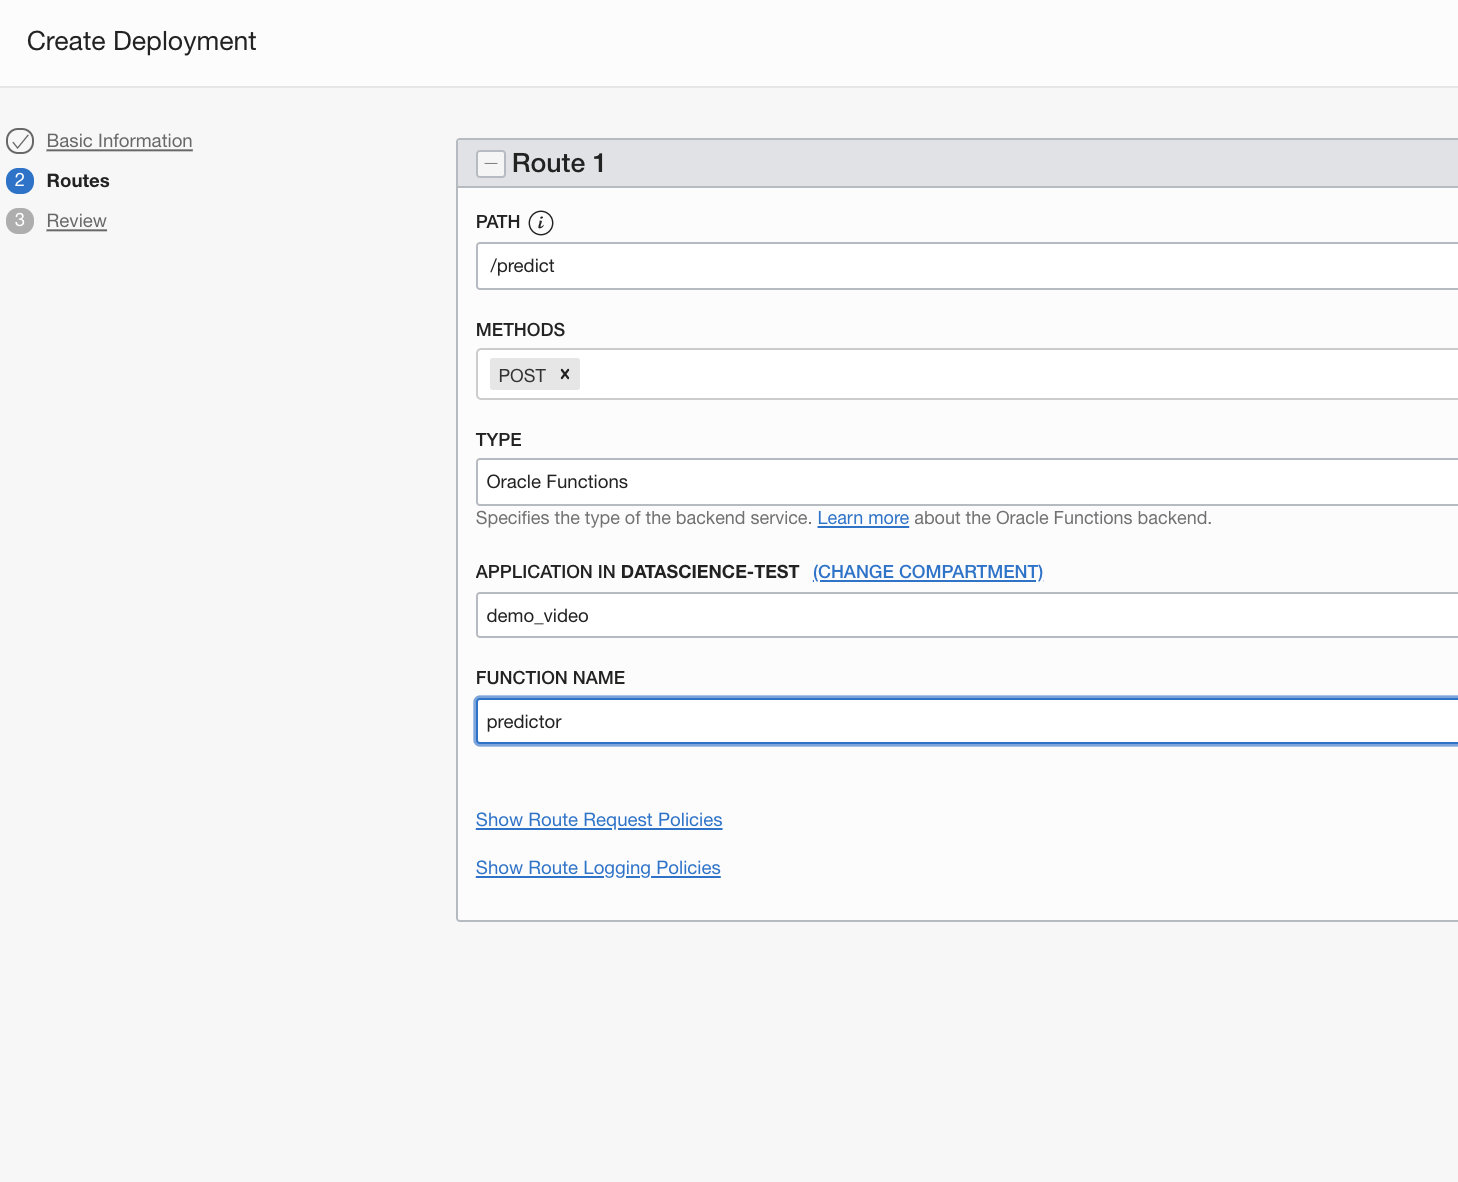

4)	Copy your API Gateway deployment URL and append to it the function endpoint you defined in previous step, for example ( /predict ). 

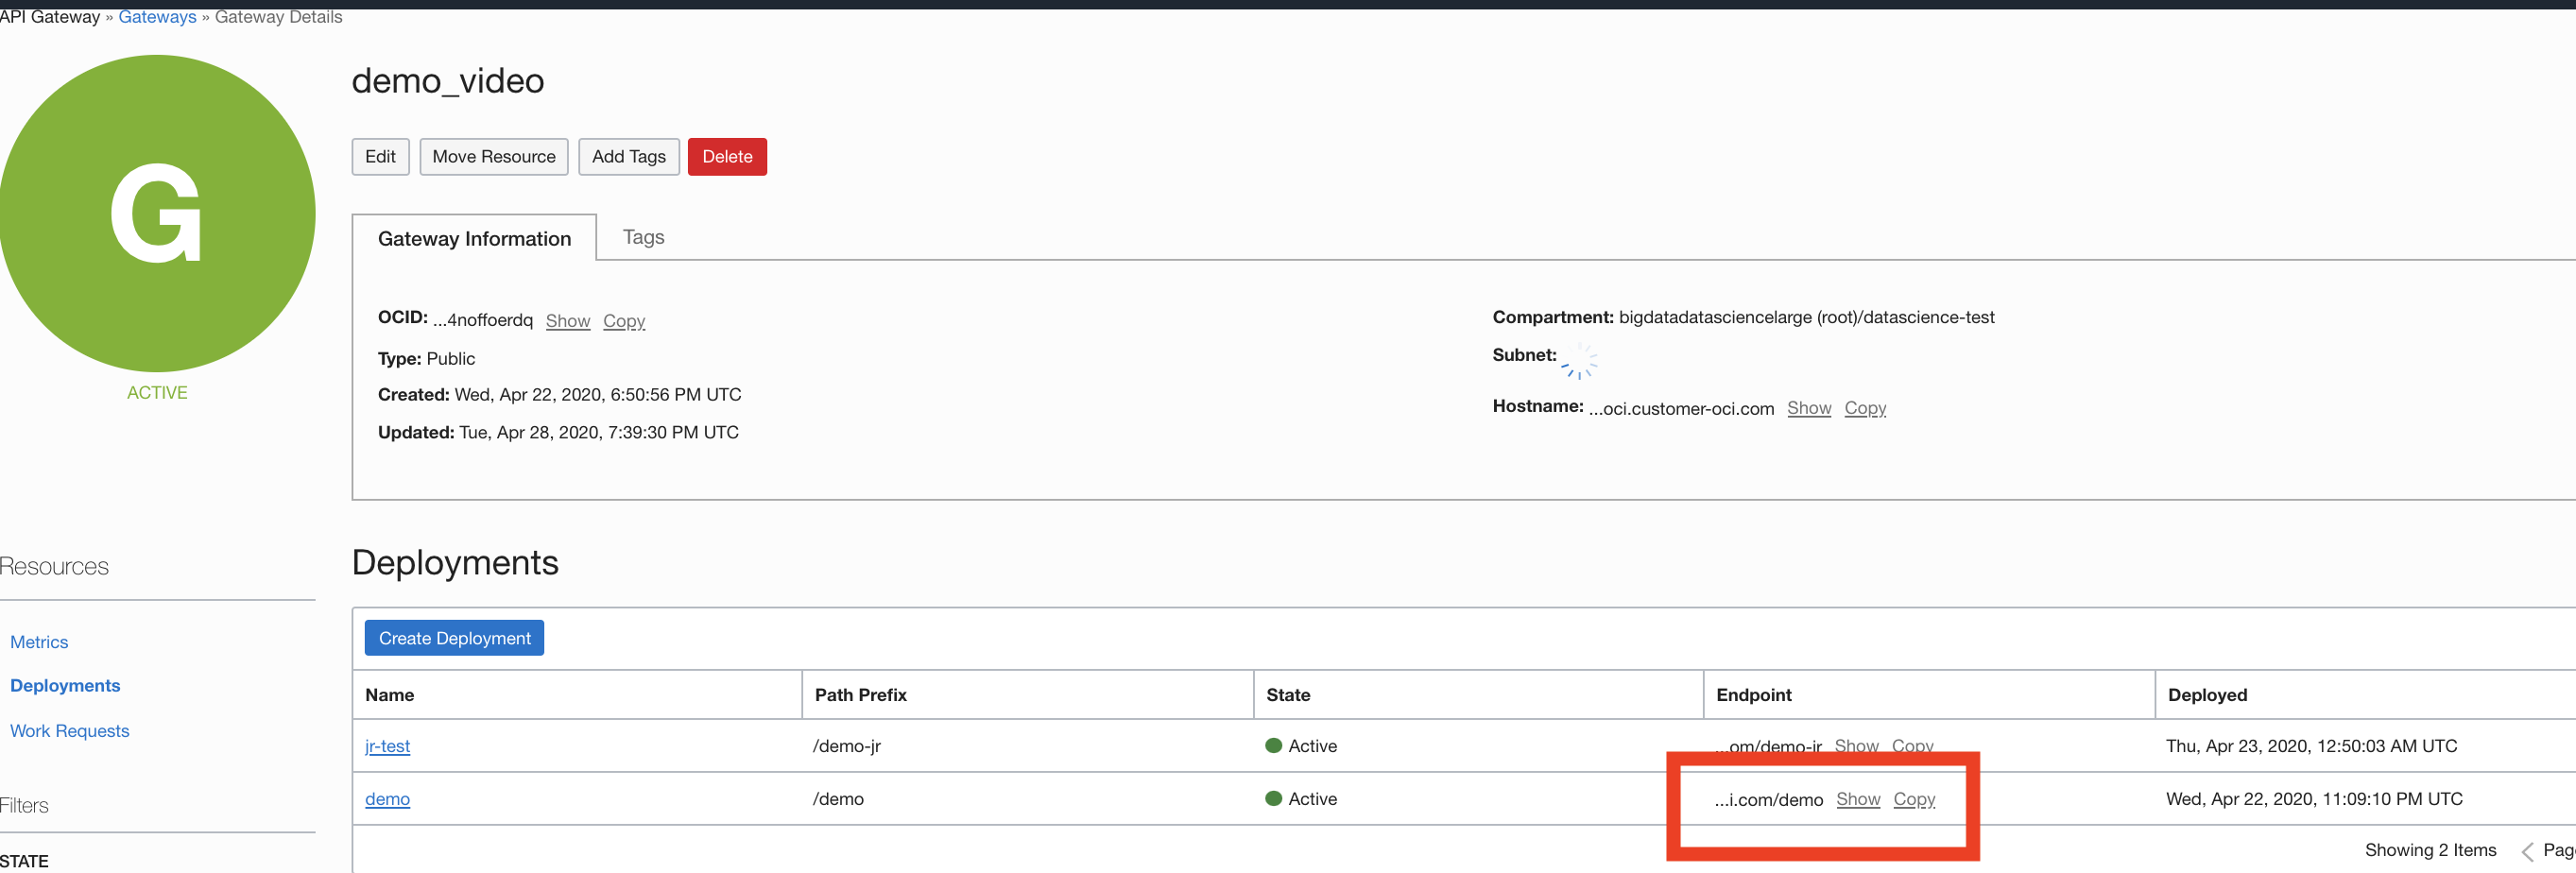

5)	You can make a POST Call in the Cloud Shell Terminal and pass in the payload.

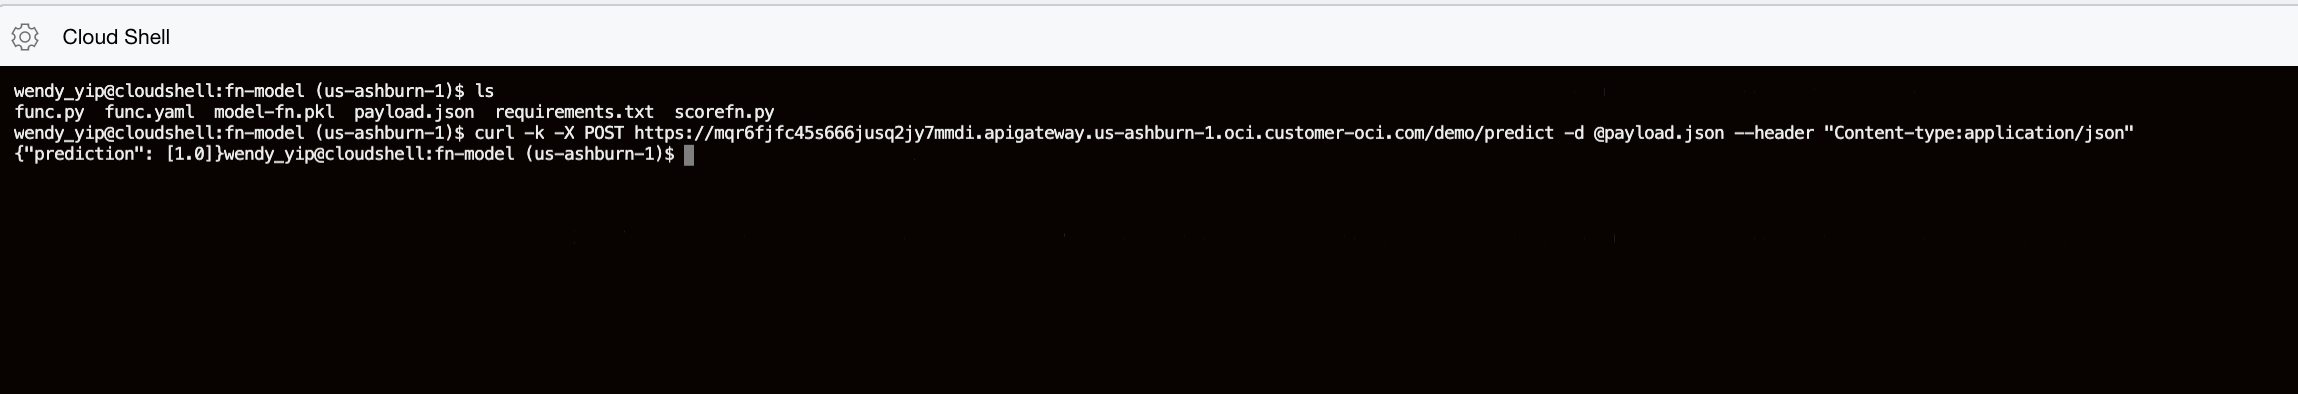

6) You can track metrics such as the number of requests and latency of the API Gateway under the Metrics tab.

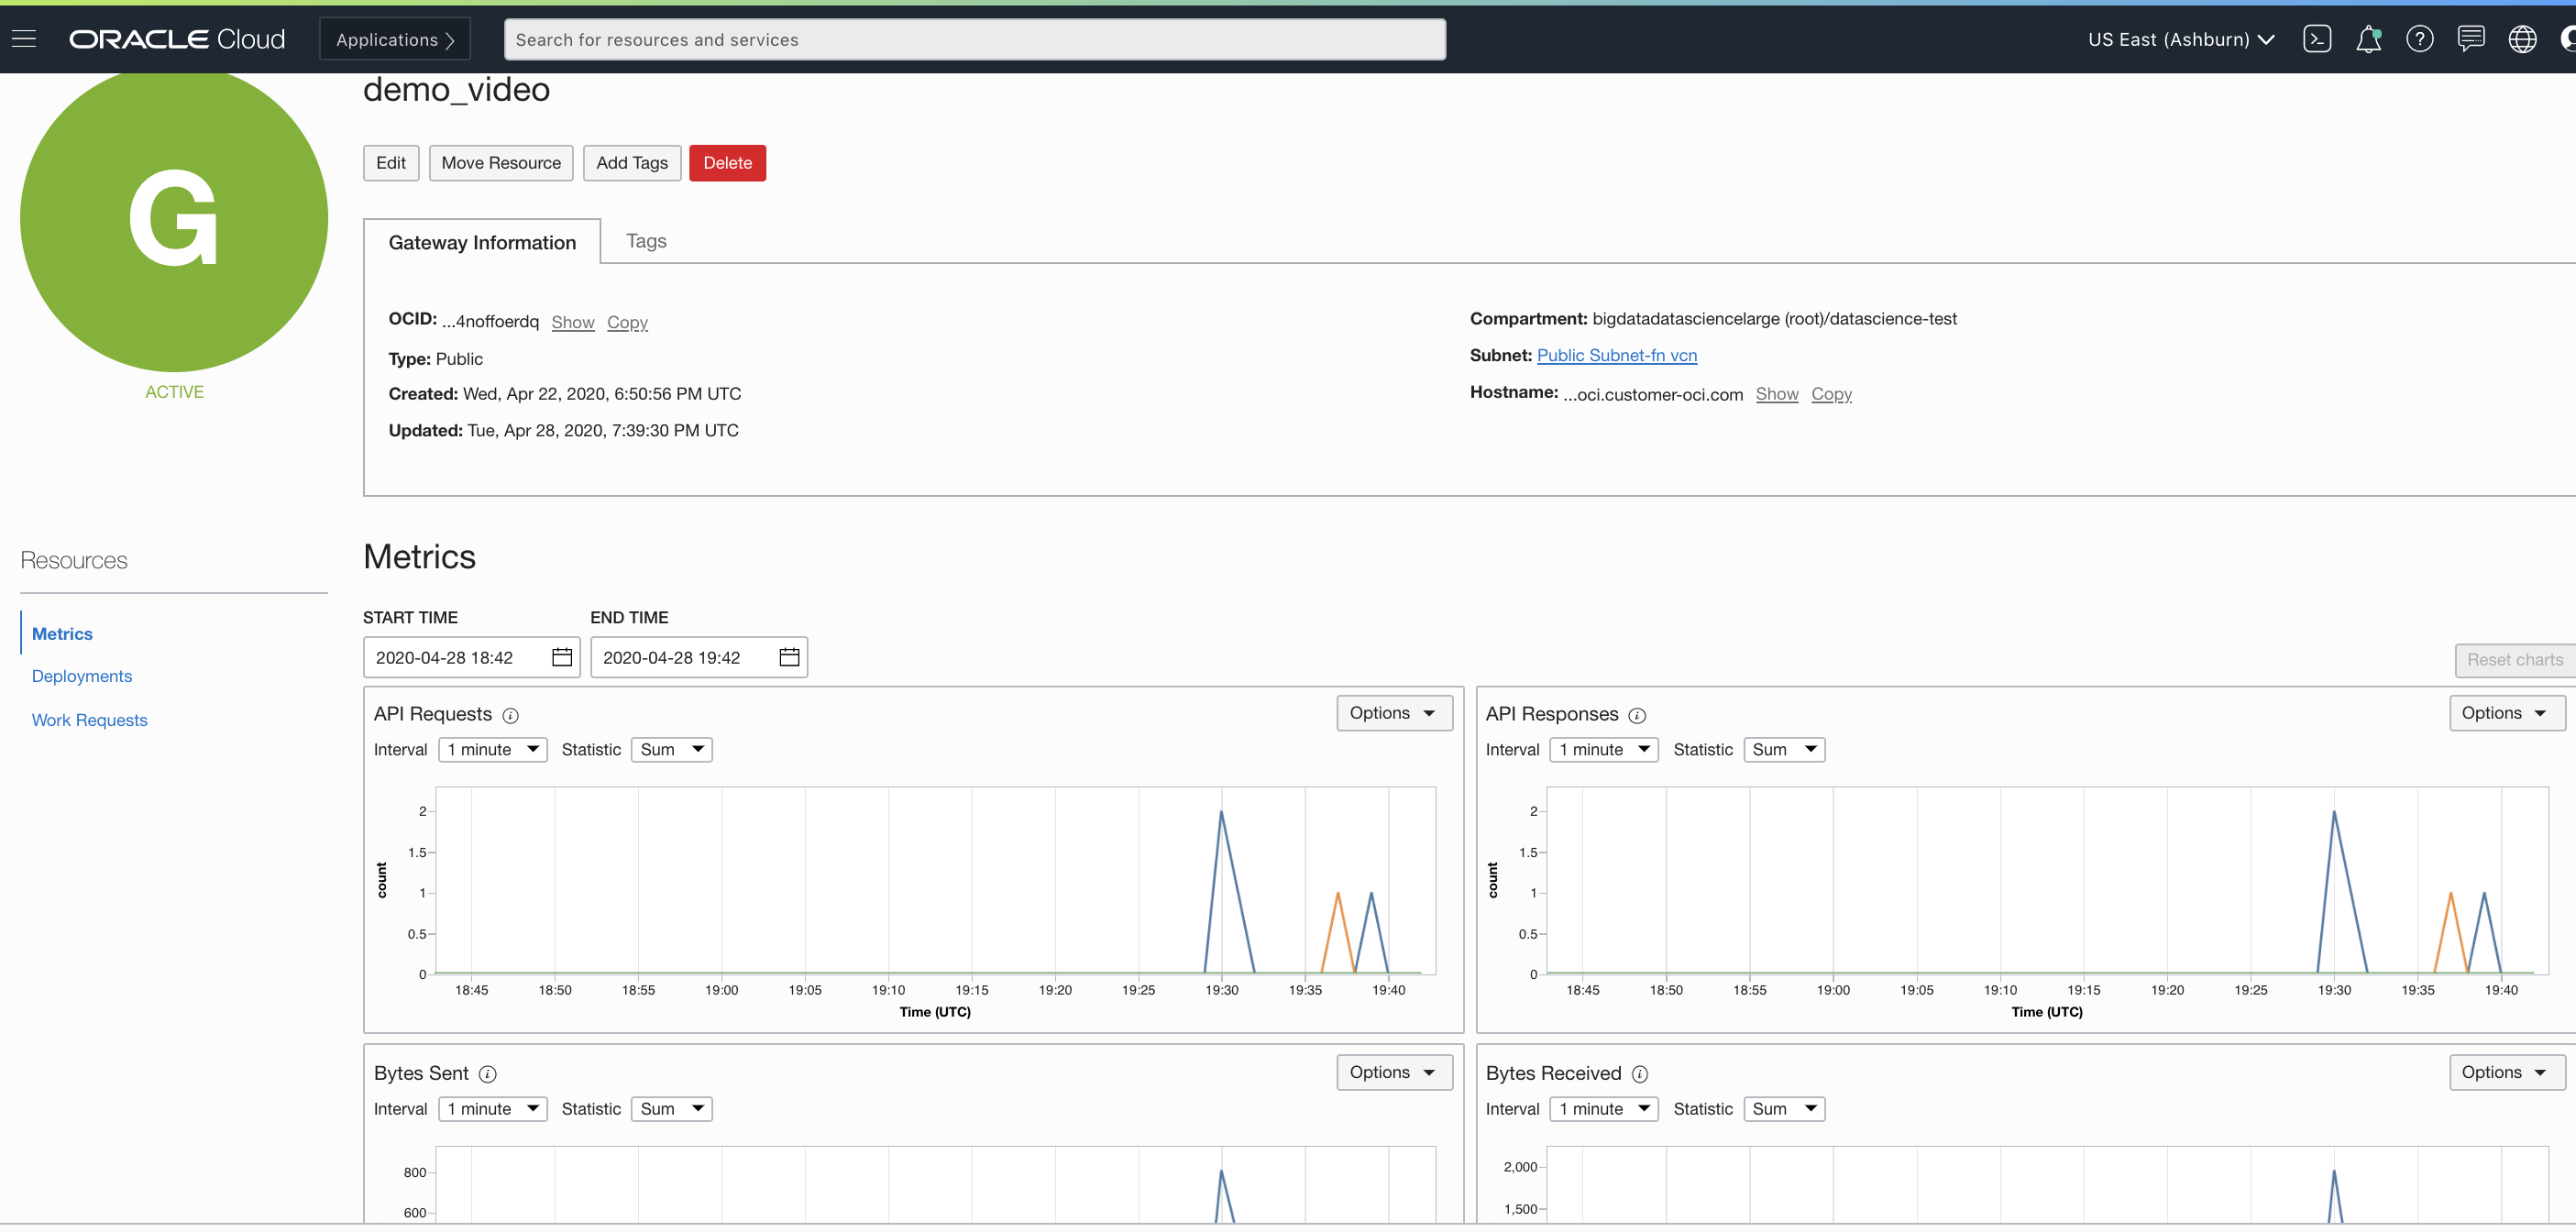